Looking at team performance, "overall" level (as opposed to daily). Inlcudes analysis of both subjective and objective performance data.

In [1]:
from __future__ import absolute_import, division, print_function
import datetime

import pandas as pd
import scipy.stats  as stats
from scipy import special
import numpy as np

import statsmodels.api as sm

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns
import imgkit


import sys
sys.path.insert(0, '../../../src/data/')

from config import *
from analysis_connections import generate_analysis_connections_store_key

2019-04-07 16:53:02,707 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown


# General prep

## Create company dyands
Creates a list of dyands within the company

Here, we'll use a cartasian join to create all the combinations among people in teh same comapny. To simplify, we'll only keep one copy of each dyad, with the lower key first (just like in the m2m table)


In [2]:
members_panel = pd.read_hdf(analysis_notebooks_store_path, 'panels/members_panel')

In [3]:
company_dyads = members_panel.reset_index()[['member','company','is_ceo']]
company_dyads = pd.merge(company_dyads,company_dyads,on='company')
company_dyads = company_dyads.rename(columns=
    {
        'member_x':'member1', 'member_y':'member2',
        'is_ceo_x':'is_ceo1', 'is_ceo_y':'is_ceo2',
    }
)

print(len(company_dyads))
company_dyads = company_dyads[company_dyads.member1 < company_dyads.member2]
print(len(company_dyads))
company_dyads.head()

564
234


,member1,company,is_ceo1,member2,is_ceo2
1,1BFLH7NZGE,Company B,1,WLA510JNBN,0
2,1BFLH7NZGE,Company B,1,76B60URM93,0
3,1BFLH7NZGE,Company B,1,P95P5A6IP2,0
9,76B60URM93,Company B,0,WLA510JNBN,0
11,76B60URM93,Company B,0,P95P5A6IP2,0


## Load daily survey data

In [4]:
daily_survey_data_clean = pd.read_hdf(surveys_clean_store_path, 'daily/daily_survey_data_clean')
daily_survey_data_clean = daily_survey_data_clean.reset_index()

## Load company panels

In [52]:
company_panel = pd.read_hdf(analysis_notebooks_store_path, 'panels/company_panel')

In [53]:
company_panel.head()

,members_count,dyads_count,m1_rank,m2_rank,m3_rank,m123_rank,m123_total,m1_rank_percentile,m2_rank_percentile,m3_rank_percentile,...,Q1_mean,Q1_count,Q1_min,Q1_max,Q1_var,Q2_mean,Q2_count,Q2_min,Q2_max,Q2_var
company,,,,,,,,,,,,,,,,,,,,,
Company A,4,6,2,2,10,3,17750.0,0.175,0.150,0.575,...,6.017544,57,3.0,7.0,1.338972,6.087719,57,2.0,7.0,1.152882
Company B,4,6,2,9,10,8,16700.0,0.175,0.475,0.575,...,5.500000,79,1.0,7.0,1.365385,5.948718,78,3.0,7.0,0.958375
Company C,4,6,14,1,19,13,15850.0,0.725,0.050,0.950,...,6.054217,83,3.0,7.0,0.975683,6.295181,83,3.0,7.0,0.719733
Company D,2,1,7,9,3,5,16950.0,0.425,0.475,0.200,...,5.046512,43,3.0,7.0,0.997785,5.047619,42,2.0,6.0,0.973287
Company E,2,1,16,13,14,17,14550.0,0.825,0.650,0.725,...,5.562500,48,4.0,7.0,0.549202,5.791667,48,4.0,7.0,0.423759


# Overall - prep data

## Aggregate company level interaction

In [7]:
RSSI_THRESHOLD = -62
store_key = generate_analysis_connections_store_key(RSSI_THRESHOLD,'m2m_dbl_annual')
m2m_dbl_annual_62 = pd.read_hdf(analysis_store_path, store_key)

In [8]:
def entropy(series, base=None):
    # number of elements for normalization
    k = len(series)
    log_k = np.log(k)
    
    if k == 1: #can't work with one dyad...
        return np.nan
    
    # calculate probabilities 
    sum_minutes = sum(series)
    if sum_minutes == 0:
        return np.nan #
    
    p = series / sum_minutes
    s_ent = special.entr(p)
    ent = sum(s_ent)/log_k
    return ent

In [9]:
# Aggregate by company
company_dyads_annual_minutes = pd.merge(
    company_dyads,m2m_dbl_annual_62.reset_index()
    ,left_on=['member1','member2']
    ,right_on=['member1','member2']
    ,how='left')
company_dyads_annual_minutes.drop(['datetime'], axis=1, inplace=True)

company_dyads_annual_minutes['minutes_62'] = company_dyads_annual_minutes['minutes'].fillna(value=0.0)
del company_dyads_annual_minutes['minutes']


company_dyads_annual_minutes = company_dyads_annual_minutes\
    .set_index('company')['minutes_62']\
    .groupby('company').agg(['sum','mean','var','std',entropy])\
    .rename(columns={'sum':'minutes_62','mean':'minutes_62_m2m_mean','var':'minutes_62_m2m_var','std':'minutes_62_m2m_std','entropy':'minutes_62_m2m_entropy'})

company_dyads_annual_minutes.head()

,minutes_62,minutes_62_m2m_mean,minutes_62_m2m_var,minutes_62_m2m_std,minutes_62_m2m_entropy
company,,,,,
Company A,3573.50,595.583333,251479.041667,501.476861,0.829846
Company B,5190.75,865.125000,83966.293750,289.769380,0.973392
Company C,7423.00,1237.166667,956245.366667,977.877992,0.867212
Company D,919.25,919.250000,NaN,NaN,NaN
Company E,913.75,913.750000,NaN,NaN,NaN


In [10]:
# Add normalized columns
columns_to_normalize = ['minutes_62']
company_dyads_annual_minutes = company_dyads_annual_minutes.join(company_panel[['members_count','dyads_count']])

for c in columns_to_normalize:
    company_dyads_annual_minutes[c+"_norm_members"]=company_dyads_annual_minutes[c]/company_dyads_annual_minutes['members_count']
    company_dyads_annual_minutes[c+"_norm_dyads"]=company_dyads_annual_minutes[c]/company_dyads_annual_minutes['dyads_count']

company_dyads_annual_minutes.head()

,minutes_62,minutes_62_m2m_mean,minutes_62_m2m_var,minutes_62_m2m_std,minutes_62_m2m_entropy,members_count,dyads_count,minutes_62_norm_members,minutes_62_norm_dyads
company,,,,,,,,,
Company A,3573.50,595.583333,251479.041667,501.476861,0.829846,4.0,6.0,893.3750,595.583333
Company B,5190.75,865.125000,83966.293750,289.769380,0.973392,4.0,6.0,1297.6875,865.125000
Company C,7423.00,1237.166667,956245.366667,977.877992,0.867212,4.0,6.0,1855.7500,1237.166667
Company D,919.25,919.250000,NaN,NaN,NaN,2.0,1.0,459.6250,919.250000
Company E,913.75,913.750000,NaN,NaN,NaN,2.0,1.0,456.8750,913.750000


## Intra team communication

In [11]:
store_key = generate_analysis_connections_store_key(RSSI_THRESHOLD,'c2c_dbl_annual')
c2c_dbl_annual_62 = pd.read_hdf(analysis_store_path, store_key)

In [12]:
c2c_out_62 = c2c_dbl_annual_62.reset_index().copy()

# cleanup 
companies_to_exclude = ['Company Q','Company J','Staff','EIR']
c2c_out_62 = c2c_out_62.loc[~c2c_out_62.company2.isin(companies_to_exclude)]
c2c_out_62 = c2c_out_62.loc[~c2c_out_62.company1.isin(companies_to_exclude)]
c2c_out_62 = c2c_out_62.loc[c2c_out_62.company1 != c2c_out_62.company2]

c2c_out_62 = c2c_out_62.rename(columns={'minutes':'minutes_out_62'})
c2c_out_62 = c2c_out_62.rename(columns={'company1':'company'})


# groupby
c2c_out_62 = c2c_out_62\
    .set_index('company')['minutes_out_62']\
    .groupby('company').agg(['sum','mean','var','std',entropy])\
    .rename(columns={'sum':'minutes_out_62','mean':'minutes_out_62_c2c_mean','var':'minutes_out_62_c2c_var','std':'minutes_out_62_c2c_std','entropy':'minutes_out_62_c2c_entropy'})



In [13]:
# Add normalized columns
columns_to_normalize = ['minutes_out_62']
c2c_out_62 = c2c_out_62.join(company_panel[['members_count','dyads_count']])

for c in columns_to_normalize:
    c2c_out_62[c+"_norm_members"]=c2c_out_62[c]/c2c_out_62['members_count']
    c2c_out_62[c+"_norm_dyads"]=c2c_out_62[c]/c2c_out_62['dyads_count']


In [14]:
del c2c_out_62['dyads_count']
del c2c_out_62['members_count']

In [15]:
c2c_out_62

,minutes_out_62,minutes_out_62_c2c_mean,minutes_out_62_c2c_var,minutes_out_62_c2c_std,minutes_out_62_c2c_entropy,minutes_out_62_norm_members,minutes_out_62_norm_dyads
company,,,,,,,
Company A,2914.00,182.125000,23511.350000,153.334112,0.891438,728.500000,485.666667
Company B,2927.50,182.968750,24757.657292,157.345662,0.878321,731.875000,487.916667
Company C,6162.75,385.171875,80003.264323,282.848483,0.904234,1540.687500,1027.125000
Company D,1121.25,70.078125,2233.855990,47.263686,0.919176,560.625000,1121.250000
Company E,2365.25,147.828125,12314.114323,110.968979,0.912959,1182.625000,2365.250000
Company F,4144.50,259.031250,54050.648958,232.487954,0.891840,1381.500000,1381.500000
Company G,5157.00,322.312500,46817.820833,216.374261,0.926846,1289.250000,859.500000
Company H,1330.00,83.125000,10583.116667,102.874276,0.823095,443.333333,443.333333
Company I,1772.50,110.781250,15713.598958,125.353895,0.839127,443.125000,295.416667


## EIR/Staff communication

In [16]:
c2c_eirstaff_62 = c2c_dbl_annual_62.reset_index().copy()

# cleanup 
companies_to_keep = ['EIR']
c2c_eirstaff_62 = c2c_eirstaff_62.loc[c2c_eirstaff_62.company2.isin(companies_to_keep)]

c2c_eirstaff_62 = c2c_eirstaff_62.rename(columns={'minutes':'minutes_eir_62'})
c2c_eirstaff_62 = c2c_eirstaff_62.rename(columns={'company1':'company'})


# groupby
c2c_eirstaff_62 = c2c_eirstaff_62\
    .set_index('company')['minutes_eir_62']\
    .groupby('company').agg(['sum'])\
    .rename(columns={'sum':'minutes_eir_62'})

In [17]:
# Add normalized columns
columns_to_normalize = ['minutes_eir_62']
c2c_eirstaff_62 = c2c_eirstaff_62.join(company_panel[['members_count','dyads_count']])

for c in columns_to_normalize:
    c2c_eirstaff_62[c+"_norm_members"]=c2c_eirstaff_62[c]/c2c_eirstaff_62['members_count']
    c2c_eirstaff_62[c+"_norm_dyads"]=c2c_eirstaff_62[c]/c2c_eirstaff_62['dyads_count']


In [18]:
del c2c_eirstaff_62['dyads_count']
del c2c_eirstaff_62['members_count']

## Agg daily survey data

Calculate regular means

In [19]:
company_daily_survey_agg_annual = daily_survey_data_clean.join(members_panel['company'], on='member') \
    .groupby('company')[['Q1','Q2']].agg(['min','max','mean','var','std'])
company_daily_survey_agg_annual.columns = ["_".join(x) for x in company_daily_survey_agg_annual.columns.ravel()]
company_daily_survey_agg_annual.head(5)

,Q1_min,Q1_max,Q1_mean,Q1_var,Q1_std,Q2_min,Q2_max,Q2_mean,Q2_var,Q2_std
company,,,,,,,,,,
Company A,3.0,7.0,6.017544,1.338972,1.157140,2.0,7.0,6.087719,1.152882,1.073724
Company B,1.0,7.0,5.500000,1.365385,1.168497,3.0,7.0,5.948718,0.958375,0.978966
Company C,3.0,7.0,6.054217,0.975683,0.987767,3.0,7.0,6.295181,0.719733,0.848371
Company D,3.0,7.0,5.046512,0.997785,0.998892,2.0,6.0,5.047619,0.973287,0.986553
Company E,4.0,7.0,5.562500,0.549202,0.741082,4.0,7.0,5.791667,0.423759,0.650968


Calculate mean of daily means

In [20]:
daily_survey_mean_daily = daily_survey_data_clean.join(members_panel['company'], on='member')

#daily_survey_mean_daily.set_index(['effective_ts'] ,inplace=True)
daily_survey_mean_daily = daily_survey_mean_daily.groupby([
        pd.Grouper(key='effective_ts', freq='D'), 
        'company'
    ])[['Q1','Q2']].agg(['mean','var','std'])
daily_survey_mean_daily.columns = ["_".join(x)+"_daily" for x in daily_survey_mean_daily.columns.ravel()]
daily_survey_mean_daily = daily_survey_mean_daily.reset_index()
del daily_survey_mean_daily['effective_ts']

daily_survey_mean_daily = daily_survey_mean_daily.groupby('company').agg(['mean','var','std'])
daily_survey_mean_daily.columns = ["_".join(x) for x in daily_survey_mean_daily.columns.ravel()]
daily_survey_mean_daily.head()

,Q1_mean_daily_mean,Q1_mean_daily_var,Q1_mean_daily_std,Q1_var_daily_mean,Q1_var_daily_var,Q1_var_daily_std,Q1_std_daily_mean,Q1_std_daily_var,Q1_std_daily_std,Q2_mean_daily_mean,Q2_mean_daily_var,Q2_mean_daily_std,Q2_var_daily_mean,Q2_var_daily_var,Q2_var_daily_std,Q2_std_daily_mean,Q2_std_daily_var,Q2_std_daily_std
company,,,,,,,,,,,,,,,,,,
Company A,5.866667,0.603363,0.776764,1.627451,4.070415,2.017527,1.109385,0.421511,0.649239,6.062500,0.413651,0.643157,1.299020,2.465329,1.570137,0.996561,0.325003,0.570090
Company B,5.378205,0.789573,0.888579,1.043333,2.230394,1.493450,0.808283,0.406263,0.637387,5.785256,0.905652,0.951657,0.656667,0.960833,0.980221,0.641252,0.255690,0.505658
Company C,6.065705,0.264191,0.513995,1.018429,1.137303,1.066444,0.881274,0.251457,0.501455,6.315705,0.153357,0.391609,0.794071,0.635220,0.797007,0.789945,0.176860,0.420548
Company D,5.000000,0.727273,0.852803,0.600000,0.410526,0.640723,0.636396,0.205263,0.453060,5.000000,0.681818,0.825723,0.631579,1.078947,1.038724,0.595458,0.292398,0.540738
Company E,5.580000,0.243333,0.493288,0.630435,0.595850,0.771913,0.584132,0.302372,0.549883,5.800000,0.166667,0.408248,0.521739,0.533597,0.730477,0.491900,0.292490,0.540824


Calculate mean of members responses

In [21]:
daily_survey_mean_member = daily_survey_data_clean.join(members_panel['company'], on='member')

#daily_survey_mean_daily.set_index(['effective_ts'] ,inplace=True)
daily_survey_mean_member = daily_survey_mean_member.groupby(['member','company'])[['Q1','Q2']].agg(['mean','var','std'])
daily_survey_mean_member.columns = ["_".join(x)+"_member" for x in daily_survey_mean_member.columns.ravel()]
daily_survey_mean_member = daily_survey_mean_member.reset_index()
del daily_survey_mean_member['member']

daily_survey_mean_member = daily_survey_mean_member.groupby('company').agg(['mean','var','std'])
daily_survey_mean_member.columns = ["_".join(x) for x in daily_survey_mean_member.columns.ravel()]
daily_survey_mean_member.head()

,Q1_mean_member_mean,Q1_mean_member_var,Q1_mean_member_std,Q1_var_member_mean,Q1_var_member_var,Q1_var_member_std,Q1_std_member_mean,Q1_std_member_var,Q1_std_member_std,Q2_mean_member_mean,Q2_mean_member_var,Q2_mean_member_std,Q2_var_member_mean,Q2_var_member_var,Q2_var_member_std,Q2_std_member_mean,Q2_std_member_var,Q2_std_member_std
company,,,,,,,,,,,,,,,,,,
Company A,6.225000,0.694167,0.833167,0.721372,0.552882,0.743561,0.703309,0.302304,0.549822,6.229167,0.348958,0.590727,0.840171,0.525333,0.724799,0.853539,0.148856,0.385819
Company B,5.545776,0.408291,0.638976,0.984629,1.194052,1.092727,0.874537,0.293086,0.541374,5.956289,0.153525,0.391823,0.798060,0.177185,0.420934,0.868344,0.058719,0.242319
Company C,5.891538,0.947056,0.973168,0.396703,0.132601,0.364144,0.527456,0.157991,0.397480,6.146923,0.612807,0.782820,0.369670,0.196636,0.443436,0.490565,0.172022,0.414755
Company D,5.051948,0.109293,0.330595,0.977922,0.575372,0.758533,0.947531,0.160215,0.400268,5.047619,0.000000,0.000000,0.997619,0.605000,0.777817,0.956538,0.165307,0.406579
Company E,5.562500,0.313368,0.559793,0.397645,0.144745,0.380454,0.587569,0.104816,0.323753,5.791667,0.125000,0.353553,0.367754,0.046314,0.215206,0.592683,0.032961,0.181553


## Agg m2c data

In [22]:
RSSI_THRESHOLD
store_key = generate_analysis_connections_store_key(RSSI_THRESHOLD,'m2c_annual')
m2c_annual_62 = pd.read_hdf(analysis_store_path, store_key)

In [23]:
# Aggregate, make sure all members are there
company_member_annual_minutes = pd.merge(
    members_panel[['company']].reset_index(),m2c_annual_62.reset_index()
    ,left_on=['member']
    ,right_on=['member1']
    ,how='left')

company_member_annual_minutes.drop(['datetime'], axis=1, inplace=True)

company_member_annual_minutes['minutes_62'] = company_member_annual_minutes['minutes'].fillna(value=0.0)
del company_member_annual_minutes['minutes']


company_member_annual_minutes = company_member_annual_minutes\
    .set_index('company')['minutes_62']\
    .groupby('company').agg(['sum','mean','var','std',entropy])\
    .rename(columns={'sum':'minutes_62','mean':'minutes_62_m2c_mean','var':'minutes_62_m2c_var','std':'minutes_62_m2c_std','entropy':'minutes_62_m2c_entropy'})

company_member_annual_minutes.head()

,minutes_62,minutes_62_m2c_mean,minutes_62_m2c_var,minutes_62_m2c_std,minutes_62_m2c_entropy
company,,,,,
Company A,11370.0,138.658537,173227.352642,416.205902,0.657556
Company B,14270.5,169.886905,309085.422296,555.954515,0.596845
Company C,22672.5,286.993671,770022.743549,877.509398,0.610043
Company D,3630.5,86.440476,39997.846980,199.994617,0.660936
Company E,4916.5,117.059524,37749.627468,194.292634,0.802190


## Prepare milestone data

In [54]:
company_panel.columns

Index([u'members_count', u'dyads_count', u'm1_rank', u'm2_rank', u'm3_rank',
       u'm123_rank', u'm123_total', u'm1_rank_percentile',
       u'm2_rank_percentile', u'm3_rank_percentile', u'm123_rank_percentile',
       u'm123_total_percentile', u'Q1_mean', u'Q1_count', u'Q1_min', u'Q1_max',
       u'Q1_var', u'Q2_mean', u'Q2_count', u'Q2_min', u'Q2_max', u'Q2_var'],
      dtype='object')

In [55]:
milesone_ranking = company_panel[['m1_rank','m2_rank','m3_rank','m123_rank','m123_total']].copy()
milesone_ranking['m_rank_var'] = company_panel[['m1_rank','m2_rank','m3_rank']].var(axis=1)
milesone_ranking

,m1_rank,m2_rank,m3_rank,m123_rank,m123_total,m_rank_var
company,,,,,,
Company A,2,2,10,3,17750.0,21.333333
Company B,2,9,10,8,16700.0,19.000000
Company C,14,1,19,13,15850.0,86.333333
Company D,7,9,3,5,16950.0,9.333333
Company E,16,13,14,17,14550.0,2.333333
Company F,1,7,6,1,17875.0,10.333333
Company G,7,2,10,4,17400.0,16.333333
Company H,12,2,16,10,16450.0,52.000000
Company I,18,8,10,14,14950.0,28.000000


## Combine

In [56]:
# add minutues (company level)
company_dyads_annual_full = company_daily_survey_agg_annual.join(company_dyads_annual_minutes)

# add minutues outside the company
company_dyads_annual_full = company_dyads_annual_full.join(c2c_out_62)

# add eir staff data
company_dyads_annual_full = company_dyads_annual_full.join(c2c_eirstaff_62)

# daily survey - company level
company_dyads_annual_full = company_dyads_annual_full.join(daily_survey_mean_daily)

# daily survey - member level
company_dyads_annual_full = company_dyads_annual_full.join(daily_survey_mean_member)

# m2c data
company_dyads_annual_full = company_dyads_annual_full.join(company_member_annual_minutes['minutes_62_m2c_entropy'])

# milestone info
company_dyads_annual_full = company_dyads_annual_full.join(milesone_ranking)

company_dyads_annual_full

,Q1_min,Q1_max,Q1_mean,Q1_var,Q1_std,Q2_min,Q2_max,Q2_mean,Q2_var,Q2_std,...,Q2_std_member_mean,Q2_std_member_var,Q2_std_member_std,minutes_62_m2c_entropy,m1_rank,m2_rank,m3_rank,m123_rank,m123_total,m_rank_var
company,,,,,,,,,,,,,,,,,,,,,
Company A,3.0,7.0,6.017544,1.338972,1.157140,2.0,7.0,6.087719,1.152882,1.073724,...,0.853539,0.148856,0.385819,0.657556,2,2,10,3,17750.0,21.333333
Company B,1.0,7.0,5.500000,1.365385,1.168497,3.0,7.0,5.948718,0.958375,0.978966,...,0.868344,0.058719,0.242319,0.596845,2,9,10,8,16700.0,19.000000
Company C,3.0,7.0,6.054217,0.975683,0.987767,3.0,7.0,6.295181,0.719733,0.848371,...,0.490565,0.172022,0.414755,0.610043,14,1,19,13,15850.0,86.333333
Company D,3.0,7.0,5.046512,0.997785,0.998892,2.0,6.0,5.047619,0.973287,0.986553,...,0.956538,0.165307,0.406579,0.660936,7,9,3,5,16950.0,9.333333
Company E,4.0,7.0,5.562500,0.549202,0.741082,4.0,7.0,5.791667,0.423759,0.650968,...,0.592683,0.032961,0.181553,0.802190,16,13,14,17,14550.0,2.333333
Company F,2.0,7.0,5.879630,1.008823,1.004402,4.0,7.0,6.203704,0.580363,0.761816,...,0.769615,0.039141,0.197840,0.664685,1,7,6,1,17875.0,10.333333
Company G,2.0,7.0,5.888889,1.075000,1.036822,3.0,7.0,5.839506,1.267670,1.125908,...,0.994368,0.108550,0.329470,0.563945,7,2,10,4,17400.0,16.333333
Company H,2.0,7.0,4.970149,1.605156,1.266948,1.0,7.0,4.985075,2.014925,1.419481,...,1.407735,0.211151,0.459511,0.559653,12,2,16,10,16450.0,52.000000
Company I,2.0,7.0,5.983333,1.474294,1.214205,3.0,7.0,5.900000,1.820339,1.349199,...,0.776591,0.244836,0.494809,0.608182,18,8,10,14,14950.0,28.000000


In [57]:
company_dyads_annual_full.head()

,Q1_min,Q1_max,Q1_mean,Q1_var,Q1_std,Q2_min,Q2_max,Q2_mean,Q2_var,Q2_std,...,Q2_std_member_mean,Q2_std_member_var,Q2_std_member_std,minutes_62_m2c_entropy,m1_rank,m2_rank,m3_rank,m123_rank,m123_total,m_rank_var
company,,,,,,,,,,,,,,,,,,,,,
Company A,3.0,7.0,6.017544,1.338972,1.157140,2.0,7.0,6.087719,1.152882,1.073724,...,0.853539,0.148856,0.385819,0.657556,2,2,10,3,17750.0,21.333333
Company B,1.0,7.0,5.500000,1.365385,1.168497,3.0,7.0,5.948718,0.958375,0.978966,...,0.868344,0.058719,0.242319,0.596845,2,9,10,8,16700.0,19.000000
Company C,3.0,7.0,6.054217,0.975683,0.987767,3.0,7.0,6.295181,0.719733,0.848371,...,0.490565,0.172022,0.414755,0.610043,14,1,19,13,15850.0,86.333333
Company D,3.0,7.0,5.046512,0.997785,0.998892,2.0,6.0,5.047619,0.973287,0.986553,...,0.956538,0.165307,0.406579,0.660936,7,9,3,5,16950.0,9.333333
Company E,4.0,7.0,5.562500,0.549202,0.741082,4.0,7.0,5.791667,0.423759,0.650968,...,0.592683,0.032961,0.181553,0.802190,16,13,14,17,14550.0,2.333333


## Clean

Remove company Q, remove J

In [58]:
company_dyads_annual_full_clean = company_dyads_annual_full.query('company not in ("Company Q","Company J")').copy()

# this will actually remove size 2 companies...
#company_dyads_annual_full_clean = company_dyads_annual_full_clean.dropna()

In [59]:
print(len(company_dyads_annual_full_clean))
company_dyads_annual_full_clean.head()

17


,Q1_min,Q1_max,Q1_mean,Q1_var,Q1_std,Q2_min,Q2_max,Q2_mean,Q2_var,Q2_std,...,Q2_std_member_mean,Q2_std_member_var,Q2_std_member_std,minutes_62_m2c_entropy,m1_rank,m2_rank,m3_rank,m123_rank,m123_total,m_rank_var
company,,,,,,,,,,,,,,,,,,,,,
Company A,3.0,7.0,6.017544,1.338972,1.157140,2.0,7.0,6.087719,1.152882,1.073724,...,0.853539,0.148856,0.385819,0.657556,2,2,10,3,17750.0,21.333333
Company B,1.0,7.0,5.500000,1.365385,1.168497,3.0,7.0,5.948718,0.958375,0.978966,...,0.868344,0.058719,0.242319,0.596845,2,9,10,8,16700.0,19.000000
Company C,3.0,7.0,6.054217,0.975683,0.987767,3.0,7.0,6.295181,0.719733,0.848371,...,0.490565,0.172022,0.414755,0.610043,14,1,19,13,15850.0,86.333333
Company D,3.0,7.0,5.046512,0.997785,0.998892,2.0,6.0,5.047619,0.973287,0.986553,...,0.956538,0.165307,0.406579,0.660936,7,9,3,5,16950.0,9.333333
Company E,4.0,7.0,5.562500,0.549202,0.741082,4.0,7.0,5.791667,0.423759,0.650968,...,0.592683,0.032961,0.181553,0.802190,16,13,14,17,14550.0,2.333333


## Calc percentiles

In [60]:
percentiles = 3
company_dyads_annual_full_clean['minutes_62_p']              = pd.qcut(company_dyads_annual_full_clean['minutes_62'], percentiles, labels=False)
company_dyads_annual_full_clean['minutes_62_norm_members_p'] = pd.qcut(company_dyads_annual_full_clean['minutes_62_norm_members'], percentiles, labels=False)
company_dyads_annual_full_clean['minutes_62_norm_dyads_p']   = pd.qcut(company_dyads_annual_full_clean['minutes_62_norm_dyads'], percentiles, labels=False)
company_dyads_annual_full_clean['minutes_62_m2m_entropy_p']  = pd.qcut(company_dyads_annual_full_clean['minutes_62_m2m_entropy'], percentiles, labels=False)
company_dyads_annual_full_clean['minutes_62_m2c_entropy_p']  = pd.qcut(company_dyads_annual_full_clean['minutes_62_m2c_entropy'], percentiles, labels=False)

company_dyads_annual_full_clean['minutes_out_62_p']              = pd.qcut(company_dyads_annual_full_clean['minutes_out_62'], percentiles, labels=False)
company_dyads_annual_full_clean['minutes_out_62_norm_members_p'] = pd.qcut(company_dyads_annual_full_clean['minutes_out_62_norm_members'], percentiles, labels=False)
company_dyads_annual_full_clean['minutes_out_62_norm_dyads_p']   = pd.qcut(company_dyads_annual_full_clean['minutes_out_62_norm_dyads'], percentiles, labels=False)
company_dyads_annual_full_clean['minutes_out_62_c2c_entropy_p']  = pd.qcut(company_dyads_annual_full_clean['minutes_out_62_c2c_entropy'], percentiles, labels=False)

company_dyads_annual_full_clean['m123_rank_p']                    = pd.qcut(company_dyads_annual_full_clean['m123_rank'], percentiles, labels=False)
company_dyads_annual_full_clean['members_count_p']                = pd.qcut(company_dyads_annual_full_clean['members_count'], percentiles, labels=False)

company_dyads_annual_full_clean['minutes_eir_62_p']               = pd.qcut(company_dyads_annual_full_clean['minutes_eir_62'], percentiles, labels=False)
company_dyads_annual_full_clean['minutes_eir_62_norm_members_p']  = pd.qcut(company_dyads_annual_full_clean['minutes_eir_62_norm_members'], percentiles, labels=False)
company_dyads_annual_full_clean['minutes_eir_62_norm_dyads_p']    = pd.qcut(company_dyads_annual_full_clean['minutes_eir_62_norm_dyads'], percentiles, labels=False)

#company_dyads_annual_full_clean['members_count_p4']                = pd.qcut(company_dyads_annual_full_clean['members_count'], 4, labels=False)
company_dyads_annual_full_clean['minutes_62_p4']              = pd.qcut(company_dyads_annual_full_clean['minutes_62'], 4, labels=False)
company_dyads_annual_full_clean['minutes_62_p8']              = pd.qcut(company_dyads_annual_full_clean['minutes_62'], 8, labels=False)
company_dyads_annual_full_clean['minutes_out_62_norm_members_p4'] = pd.qcut(company_dyads_annual_full_clean['minutes_out_62_norm_members'], 4, labels=False)
company_dyads_annual_full_clean['minutes_62_m2c_entropy_p4']  = pd.qcut(company_dyads_annual_full_clean['minutes_62_m2c_entropy'], 4, labels=False)
company_dyads_annual_full_clean['minutes_eir_62_norm_members_p4']  = pd.qcut(company_dyads_annual_full_clean['minutes_eir_62_norm_members'], 4, labels=False)



In [61]:
company_dyads_annual_full_clean.head()

,Q1_min,Q1_max,Q1_mean,Q1_var,Q1_std,Q2_min,Q2_max,Q2_mean,Q2_var,Q2_std,...,m123_rank_p,members_count_p,minutes_eir_62_p,minutes_eir_62_norm_members_p,minutes_eir_62_norm_dyads_p,minutes_62_p4,minutes_62_p8,minutes_out_62_norm_members_p4,minutes_62_m2c_entropy_p4,minutes_eir_62_norm_members_p4
company,,,,,,,,,,,,,,,,,,,,,
Company A,3.0,7.0,6.017544,1.338972,1.157140,2.0,7.0,6.087719,1.152882,1.073724,...,0,1,1,1,0,1,2,1,2,1
Company B,1.0,7.0,5.500000,1.365385,1.168497,3.0,7.0,5.948718,0.958375,0.978966,...,1,1,1,1,1,2,4,1,1,1
Company C,3.0,7.0,6.054217,0.975683,0.987767,3.0,7.0,6.295181,0.719733,0.848371,...,2,1,2,2,1,2,5,3,1,3
Company D,3.0,7.0,5.046512,0.997785,0.998892,2.0,6.0,5.047619,0.973287,0.986553,...,0,0,1,2,2,0,0,1,2,2
Company E,4.0,7.0,5.562500,0.549202,0.741082,4.0,7.0,5.791667,0.423759,0.650968,...,2,0,0,1,2,0,0,2,3,1


## Re-rank

In [62]:
company_dyads_annual_full_clean['m123_rerank'] = company_dyads_annual_full_clean['m123_rank'].rank().astype(int)

In [63]:
company_dyads_annual_full_clean[['m123_rank','m123_rerank']].sort_values(by='m123_rank')

,m123_rank,m123_rerank
company,,
Company F,1,1
Company A,3,2
Company G,4,3
Company D,5,4
Company M,6,5
Company P,7,6
Company B,8,7
Company N,9,8
Company H,10,9


## Save for other notebook

In [64]:
with pd.HDFStore(analysis_notebooks_store_path ) as store:
    store.put('team_performance/company_dyads_annual_full_clean', company_dyads_annual_full_clean)

## Common functions

In [36]:

def corr_figure(data, question_column, minutes_column, title,ax):
    df_clean = data.copy().query(minutes_column + "==" +minutes_column)
    if len(df_clean) != len (data):
        raise Exception('Data contains nulls')        
    (c,p) = stats.pearsonr(data[question_column], data[minutes_column])
    c_str = "{:.3f}".format(c)
    p_str = "{:.3f}".format(p)
    
    plt = sns.scatterplot(x=minutes_column, y=question_column, ax=ax,
    data=data,color="blue", legend=False, hue="company")#, hue="company", palette=sns.dark_palette("purple", n_colors=19))
    
    ax.set_title(title+"\n(Correlation: "+c_str+", p-value: "+p_str+")")
    
def plot_corr(data, question_column_postfix, minutes_column, title):
    #c = data[question_column].corr(data[minutes_column])
    fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,4))
   
    corr_figure(data,"Q1"+question_column_postfix,minutes_column,"Question 1, "+title,ax)
    corr_figure(data,"Q2"+question_column_postfix,minutes_column,"Question 2, "+title,ax2)
    
    
    #df2["b"].plot(kind='barh', x='LABEL',ax=ax2)
    plt.show()
    

In [37]:
div_cmap = sns.diverging_palette(220, 10, as_cmap=True)

def colfix(df, L=5): return df.rename(columns=lambda x: ' '.join(x.replace('_', ' ')[i:i+L] for i in range(0,len(x),L)) if df[x].dtype in ['float64','int64'] else x )

def create_style_corr_table(df, cmap=div_cmap):
    s = df
    s = colfix(s, 10)
    s = s.corr().style
    s.background_gradient(cmap=cmap, axis=1)
    s.set_precision(2)
    s.set_table_styles([dict(selector="th",props=[('max-width', '80px')])])
    return s

def plot_corr_martix(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    f, ax = plt.subplots(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=div_cmap,
            square=True, ax=ax)
    

In [38]:
# Mann–Whitney U test
def compare_groups(data,question_column_postfix, column, g1,g2,test="mw"):
    """
    column - percentile/tertile/quartile column to use
    g1 - percentile values for the first group
    g2 - same for second group
    """
    print(data[column].value_counts())
    group_a = data.loc[data[column].isin(g1)]
    group_b = data.loc[data[column].isin(g2)] 

    if test == "mw":
        test_function = stats.mannwhitneyu
    elif test == "ttest":
        test_function = stats.ttest_ind
    elif test == "ks":
        test_function = stats.ks_2samp
    elif test =="wmw":
        test_function = stats.wilcoxon
    else:
        return

    print("Test: "+str(test_function))
        
    q_columns_to_test = ['_mean','_var']#,'_mean_daily_var']
    print("Group sizes: ",",",len(group_a),",",len(group_b))

    columns=[]
    for q in range (1,3):
            question_column = 'Q'+str(q)+question_column_postfix
            columns.append(question_column)
            stat, p = test_function(group_a[question_column], group_b[question_column]) # low p-value = different        
            ks_stat1, ks_p1 = stats.kstest(group_a[question_column], 'norm')
            ks_stat2, ks_p2 = stats.kstest(group_b[question_column], 'norm')
            
            ma = group_a[question_column].mean()
            mb = group_b[question_column].mean()
            sema = group_a[question_column].sem()
            semb = group_b[question_column].sem()
            print("Q{}, p: {:.2f}, Means: {:.2f} ({:.2f}),{:.2f}({:.2f})".format(q, p,ma,sema,mb,semb))
            print("KS test - Q{}: group a: {:.2f}   group b: {:.2f}".format(q,ks_p1,ks_p2)) #p <= alpha: reject H0, not normal.
            
            #stats.probplot(group_a[question_column],plot=plt)
            #plt.show()
            #group_a[question_column].hist(bins=20)
            #plt.show()
            
    ax = data.boxplot(column=columns, by=column, figsize=(10,4), grid=False, showmeans=True)

# Mann–Whitney U test
def compare_groups_milestons(data, question_column, column, g1,g2,test="mw"):
    print(data[column].value_counts())
    group_a = data.loc[data[column].isin(g1)]
    group_b = data.loc[data[column].isin(g2)] 


    if test == "mw":
        test_function = stats.mannwhitneyu
    elif test == "ttest":
        test_function = stats.ttest_ind
    elif test == "ks":
        test_function = stats.ks_2samp
    elif test =="wmw":
        test_function = stats.wilcoxon
    else:
        return

    print("Test: "+str(test_function))
    
    print("Group sizes: ",",",len(group_a),",",len(group_b))

    print("------------------------")
    print(question_column)
    stat, p = test_function(group_a[question_column], group_b[question_column]) # low p-value = different        
    ma = group_a[question_column].mean()
    mb = group_b[question_column].mean()
    sema = group_a[question_column].sem()
    semb = group_b[question_column].sem()
    mia= group_a[question_column].median()
    mib= group_b[question_column].median()
    print("p: {:.2f}, Means: {:.2f} ({:.2f}),{:.2f}({:.2f}), medians: {:.2f} {:.2f}".format(p,ma,sema,mb,semb,mia,mib))
    
    ks_stat1, ks_p1 = stats.kstest(group_a[question_column], 'norm')
    ks_stat2, ks_p2 = stats.kstest(group_b[question_column], 'norm')
    print("KS test - group a: {:.2f}   group b: {:.2f}".format(ks_p1,ks_p2)) #p <= alpha: reject H0, not normal.
    
    #stats.probplot(group_a[question_column],plot=plt)
    #plt.show()
    #group_a[question_column].hist(bins=20)
    #plt.show()
    
    ax = data.boxplot(column=[question_column], by=column, figsize=(10,4), grid=False, showmeans=True)

# Subjective performance / Daily survey data

## Explore - daily survey data - intra team

### Correalation matrices

2019-02-13 19:20:12,477 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/orenled/Envs/rhythm-private-analysis-deltav17/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2019-02-13 19:20:12,691 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans (u'/home/orenled/Envs/rhythm-private-analysis-deltav17/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


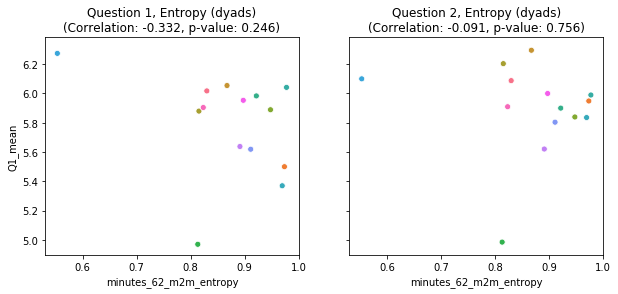

In [38]:
plot_corr(company_dyads_annual_full_clean.reset_index().dropna(), "_mean","minutes_62_m2m_entropy","Entropy (dyads)")

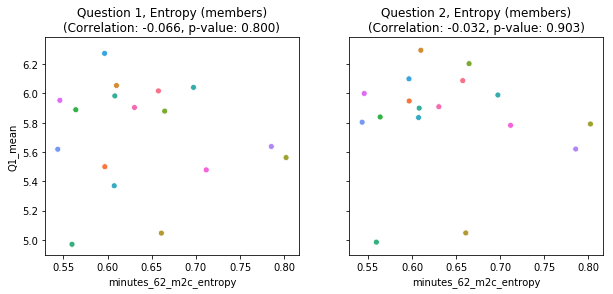

In [39]:
plot_corr(company_dyads_annual_full_clean.reset_index(), "_mean","minutes_62_m2c_entropy","Entropy (members)")

In [40]:
pairplot_columns = ['minutes_62','minutes_62_p','minutes_62_norm_members','minutes_62_norm_members_p','minutes_62_norm_dyads','minutes_62_norm_dyads_p','minutes_62_m2m_mean','minutes_62_m2m_var','minutes_62_m2m_std','minutes_62_m2m_entropy','minutes_62_m2c_entropy','members_count','dyads_count']
q1_columns = ['Q1_mean','Q1_min','Q1_var','Q1_std','Q1_mean_daily_mean','Q1_mean_daily_var','Q1_mean_daily_std','Q1_mean_member_mean','Q1_mean_member_var','Q1_mean_member_std']+pairplot_columns
q2_columns = ['Q2_mean','Q2_min','Q2_var','Q2_std','Q2_mean_daily_mean','Q2_mean_daily_var','Q2_mean_daily_std','Q2_mean_member_mean','Q2_mean_member_var','Q2_mean_member_std']+pairplot_columns

In [41]:
s = create_style_corr_table(company_dyads_annual_full_clean[q1_columns])
imgkit.from_string(s.render(), '/home/orenled/temp/q1_corr.png')
s

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,Q1 mean,Q1 min,Q1 var,Q1 std,Q1 mean da ily mean,Q1 mean da ily var,Q1 mean da ily std,Q1 mean me mber mean,Q1 mean me mber var,Q1 mean me mber std,minutes 62,minutes 62 p,minutes 62 norm memb ers,minutes 62 norm memb ers p,minutes 62 norm dyad s,minutes 62 norm dyad s p,minutes 62 m2m mean,minutes 62 m2m var,minutes 62 m2m std,minutes 62 m2m entro py,minutes 62 m2c entro py,members co unt,dyads coun t
Q1 mean,1,0.24,-0.2,-0.19,0.99,-0.4,-0.36,0.88,0.14,0.28,0.35,0.42,0.27,0.45,-0.055,-0.17,-0.055,0.32,0.26,-0.33,-0.066,0.39,0.29
Q1 min,0.24,1,-0.73,-0.72,0.33,-0.48,-0.44,0.12,0.044,0.055,-0.018,0,0.0086,0.17,0.18,0.17,0.18,0.37,0.38,-0.34,0.27,-0.14,-0.054
Q1 var,-0.2,-0.73,1,1,-0.27,0.58,0.6,-0.086,0.035,0.018,-0.32,-0.26,-0.31,-0.4,-0.39,-0.38,-0.39,-0.44,-0.47,0.0049,-0.12,0.014,-0.12
Q1 std,-0.19,-0.72,1,1,-0.26,0.59,0.61,-0.086,0.058,0.042,-0.31,-0.23,-0.28,-0.37,-0.36,-0.34,-0.36,-0.4,-0.43,0.0012,-0.14,-0.00095,-0.14
Q1 mean da ily mean,0.99,0.33,-0.27,-0.26,1,-0.46,-0.42,0.82,0.18,0.3,0.34,0.4,0.26,0.45,-0.034,-0.12,-0.034,0.33,0.27,-0.31,-0.016,0.36,0.28
Q1 mean da ily var,-0.4,-0.48,0.58,0.59,-0.46,1,0.99,-0.25,-0.21,-0.28,-0.58,-0.55,-0.32,-0.52,-0.0054,0.21,-0.0054,0.085,0.048,-0.19,0.076,-0.53,-0.59
Q1 mean da ily std,-0.36,-0.44,0.6,0.61,-0.42,0.99,1,-0.24,-0.15,-0.21,-0.63,-0.56,-0.3,-0.53,0.043,0.24,0.043,0.11,0.073,-0.18,0.13,-0.6,-0.67
Q1 mean me mber mean,0.88,0.12,-0.086,-0.086,0.82,-0.25,-0.24,1,-0.26,-0.084,0.38,0.47,0.29,0.47,-0.053,-0.21,-0.053,0.22,0.18,-0.35,-0.14,0.47,0.36
Q1 mean me mber var,0.14,0.044,0.035,0.058,0.18,-0.21,-0.15,-0.26,1,0.97,-0.2,-0.083,-0.21,-0.16,-0.16,-0.09,-0.16,0.012,0.046,-0.047,0.13,-0.16,-0.13
Q1 mean me mber std,0.28,0.055,0.018,0.042,0.3,-0.28,-0.21,-0.084,0.97,1,-0.093,0.052,-0.1,-0.029,-0.11,-0.093,-0.11,0.061,0.11,-0.044,0.019,-0.074,-0.077


In [42]:
s = create_style_corr_table(company_dyads_annual_full_clean[q2_columns])
imgkit.from_string(s.render(), '/home/orenled/temp/q2_corr.png')
s

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,Q2 mean,Q2 min,Q2 var,Q2 std,Q2 mean da ily mean,Q2 mean da ily var,Q2 mean da ily std,Q2 mean me mber mean,Q2 mean me mber var,Q2 mean me mber std,minutes 62,minutes 62 p,minutes 62 norm memb ers,minutes 62 norm memb ers p,minutes 62 norm dyad s,minutes 62 norm dyad s p,minutes 62 m2m mean,minutes 62 m2m var,minutes 62 m2m std,minutes 62 m2m entro py,minutes 62 m2c entro py,members co unt,dyads coun t
Q2 mean,1,0.48,-0.4,-0.39,0.99,-0.4,-0.4,0.93,0.23,0.31,0.38,0.53,0.37,0.55,0.13,-0.023,0.13,0.36,0.33,-0.091,-0.032,0.3,0.22
Q2 min,0.48,1,-0.74,-0.77,0.46,-0.71,-0.69,0.47,-0.088,-0.13,0.43,0.41,0.4,0.48,0.33,0.21,0.33,-0.1,-0.013,0.55,-0.011,0.2,0.26
Q2 var,-0.4,-0.74,1,0.99,-0.39,0.8,0.8,-0.38,0.45,0.42,-0.35,-0.44,-0.26,-0.5,-0.22,-0.19,-0.22,0.041,-0.0016,-0.37,-0.22,-0.22,-0.3
Q2 std,-0.39,-0.77,0.99,1,-0.37,0.8,0.81,-0.37,0.45,0.42,-0.35,-0.42,-0.24,-0.48,-0.21,-0.18,-0.21,0.046,-0.0023,-0.36,-0.21,-0.22,-0.32
Q2 mean da ily mean,0.99,0.46,-0.39,-0.37,1,-0.42,-0.43,0.91,0.28,0.37,0.38,0.52,0.35,0.53,0.092,-0.048,0.092,0.38,0.35,-0.14,-0.012,0.31,0.24
Q2 mean da ily var,-0.4,-0.71,0.8,0.8,-0.42,1,0.98,-0.35,0.00046,-0.012,-0.38,-0.43,-0.19,-0.42,-0.016,0.13,-0.016,0.32,0.26,-0.5,-0.17,-0.4,-0.45
Q2 mean da ily std,-0.4,-0.69,0.8,0.81,-0.43,0.98,1,-0.36,0.037,-0.0051,-0.46,-0.48,-0.19,-0.46,0.054,0.19,0.054,0.28,0.23,-0.41,-0.066,-0.51,-0.57
Q2 mean me mber mean,0.93,0.47,-0.38,-0.37,0.91,-0.35,-0.36,1,0.029,0.13,0.41,0.58,0.38,0.57,0.1,-0.08,0.1,0.37,0.35,-0.25,-0.15,0.39,0.3
Q2 mean me mber var,0.23,-0.088,0.45,0.45,0.28,0.00046,0.037,0.029,1,0.95,0.0026,-0.033,-0.06,-0.14,-0.21,-0.32,-0.21,-0.11,-0.13,0.071,-0.14,0.093,0.04
Q2 mean me mber std,0.31,-0.13,0.42,0.42,0.37,-0.012,-0.0051,0.13,0.95,1,0.14,0.12,0.036,-0.02,-0.22,-0.41,-0.22,-0.085,-0.11,0.0055,-0.21,0.24,0.16


### Compare populations - high interaction vs low

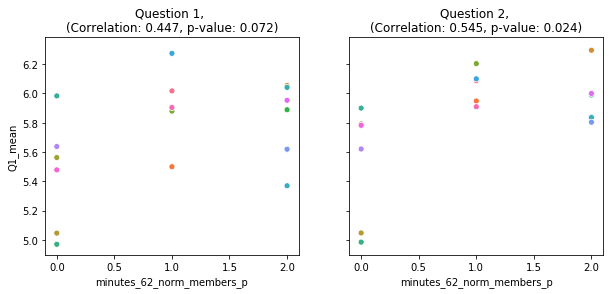

In [116]:
plot_corr(company_dyads_annual_full_clean.reset_index(), "_mean","minutes_62_norm_members_p","")

2    6
0    6
1    5
Name: minutes_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 6 , 11
Q1, p: 0.03, Means: 5.45 (0.16),5.86(0.08)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.00, Means: 5.52 (0.16),6.00(0.05)
KS test - Q2: group a: 0.00   group b: 0.00


/home/orenled/Envs/rhythm-private-analysis-deltav18-anon/lib/python2.7/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


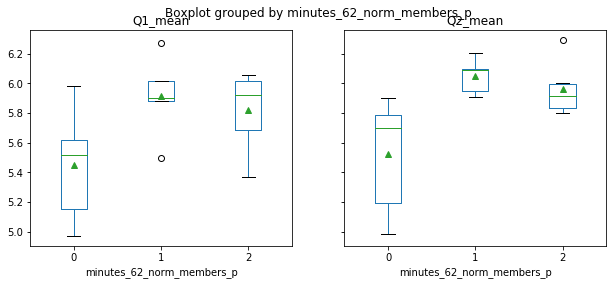

In [43]:
compare_groups(company_dyads_annual_full_clean,"_mean", 'minutes_62_norm_members_p', [0],[1,2])

2    6
0    6
1    5
Name: minutes_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 11 , 6
Q1, p: 0.04, Means: 1.19 (0.10),0.89(0.08)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.05, Means: 1.18 (0.15),0.75(0.11)
KS test - Q2: group a: 0.00   group b: 0.00


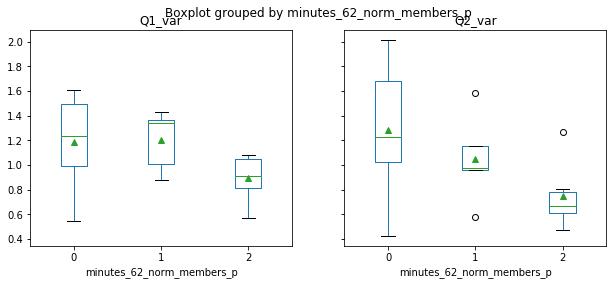

In [44]:
compare_groups(company_dyads_annual_full_clean,"_var", 'minutes_62_norm_members_p', [0,1],[2])

2    6
0    6
1    5
Name: minutes_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 6 , 5
Q1, p: 0.39, Means: 1.19 (0.17),1.20(0.11)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.21, Means: 1.28 (0.24),1.05(0.16)
KS test - Q2: group a: 0.00   group b: 0.00


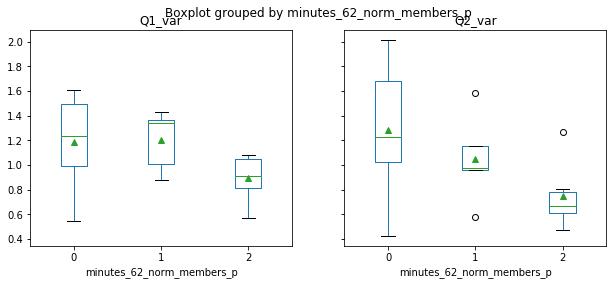

In [45]:
compare_groups(company_dyads_annual_full_clean,"_var", 'minutes_62_norm_members_p', [0],[1])

### Compare populations - high entropy vs low

2.0    5
0.0    5
1.0    4
Name: minutes_62_m2m_entropy_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 5 , 5
Q1, p: 0.42, Means: 5.81 (0.22),5.76(0.14)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.15, Means: 5.86 (0.22),5.90(0.03)
KS test - Q2: group a: 0.00   group b: 0.00


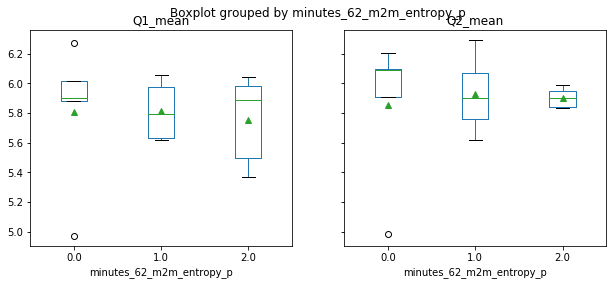

In [46]:
compare_groups(company_dyads_annual_full_clean,"_mean", 'minutes_62_m2m_entropy_p', [0],[2])

2.0    5
0.0    5
1.0    4
Name: minutes_62_m2m_entropy_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 5 , 5
Q1, p: 0.27, Means: 1.25 (0.13),1.11(0.13)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.34, Means: 1.26 (0.25),1.09(0.21)
KS test - Q2: group a: 0.00   group b: 0.00


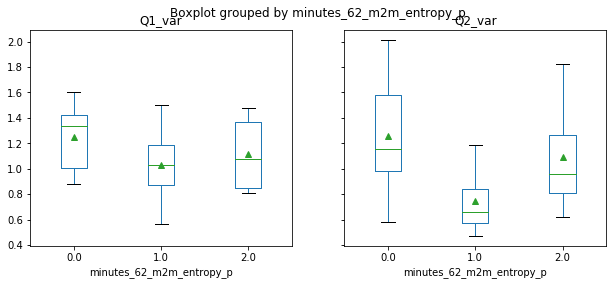

In [47]:
compare_groups(company_dyads_annual_full_clean,"_var", 'minutes_62_m2m_entropy_p', [0],[2])

### mean_daily

2    6
0    6
1    5
Name: minutes_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 11 , 6
Q1, p: 0.01, Means: 0.62 (0.07),0.31(0.06)
KS test - Q1: group a: 0.00   group b: 0.04
Q2, p: 0.03, Means: 0.67 (0.12),0.30(0.10)
KS test - Q2: group a: 0.00   group b: 0.05


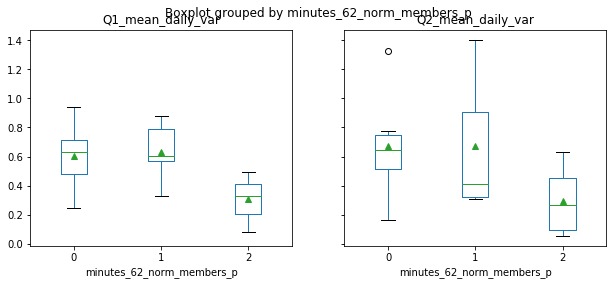

In [48]:
compare_groups(company_dyads_annual_full_clean,"_mean_daily_var", 'minutes_62_norm_members_p', [0,1],[2])

### Mean member

2    6
0    6
1    5
Name: minutes_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 6 , 11
Q1, p: 0.17, Means: 0.59 (0.33),0.45(0.08)
KS test - Q1: group a: 0.05   group b: 0.00
Q2, p: 0.48, Means: 0.42 (0.18),0.29(0.06)
KS test - Q2: group a: 0.07   group b: 0.00


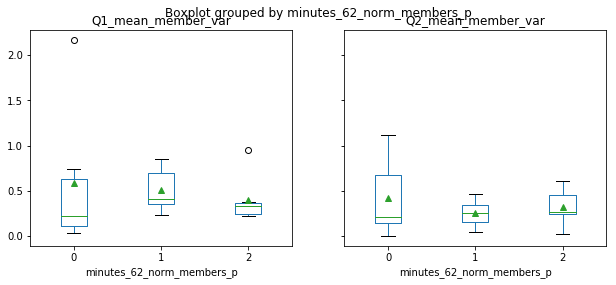

In [49]:
compare_groups(company_dyads_annual_full_clean,"_mean_member_var", 'minutes_62_norm_members_p', [0],[1,2])

### Team size vs. answers

In [50]:
company_dyads_annual_full_clean["is_46"]=0
company_dyads_annual_full_clean.loc[(company_dyads_annual_full_clean.members_count >= 4) & (company_dyads_annual_full_clean.members_count <=6), 'is_46'] = 1
print(company_dyads_annual_full_clean.is_46.value_counts())


0    9
1    8
Name: is_46, dtype: int64


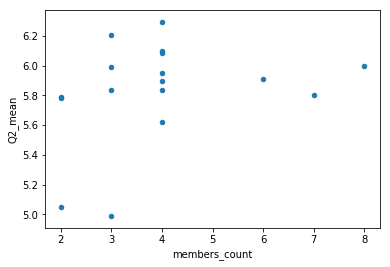

In [51]:
company_dyads_annual_full_clean.plot.scatter('members_count','Q2_mean')

0    9
1    8
Name: is_46, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 9 , 8
Q1, p: 0.02, Means: 5.55 (0.13),5.91(0.09)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.08, Means: 5.72 (0.14),5.96(0.07)
KS test - Q2: group a: 0.00   group b: 0.00


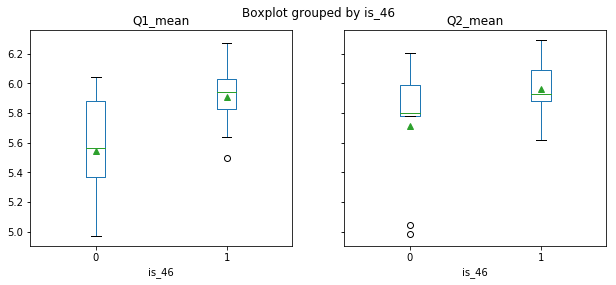

In [52]:
compare_groups(company_dyads_annual_full_clean,'_mean','is_46',[0],[1])

0    9
1    8
Name: is_46, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 9 , 8
Q1, p: 0.04, Means: 0.94 (0.10),1.25(0.09)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.04, Means: 0.86 (0.17),1.21(0.12)
KS test - Q2: group a: 0.00   group b: 0.00


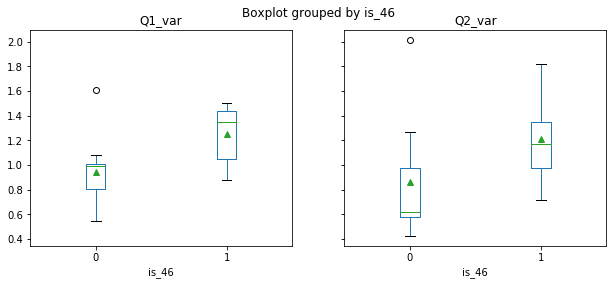

In [53]:
compare_groups(company_dyads_annual_full_clean,'_var','is_46',[0],[1])

In [54]:
company_dyads_annual_full_clean[['members_count','members_count_p']].sort_values(by=['members_count_p','members_count'])

,members_count,members_count_p
company,,
Company D,2.0,0
Company E,2.0,0
Company R,2.0,0
Company F,3.0,0
Company H,3.0,0
Company K,3.0,0
Company L,3.0,0
Company A,4.0,1
Company B,4.0,1


1    7
0    7
2    3
Name: members_count_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 7 , 10
Q1, p: 0.01, Means: 5.48 (0.15),5.88(0.07)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.07, Means: 5.66 (0.18),5.95(0.06)
KS test - Q2: group a: 0.00   group b: 0.00


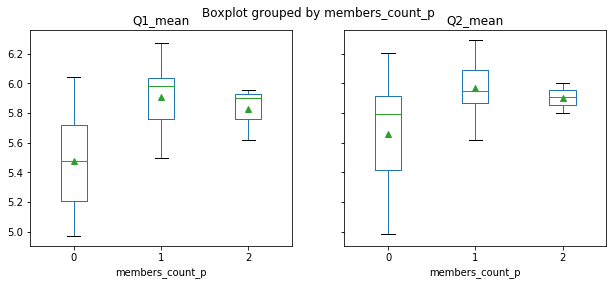

In [55]:
compare_groups(company_dyads_annual_full_clean,'_mean','members_count_p',[0],[1,2])

1    7
0    7
2    3
Name: members_count_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 7 , 10
Q1, p: 0.09, Means: 1.23 (0.09),0.99(0.11)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.04, Means: 1.24 (0.14),0.87(0.15)
KS test - Q2: group a: 0.00   group b: 0.00


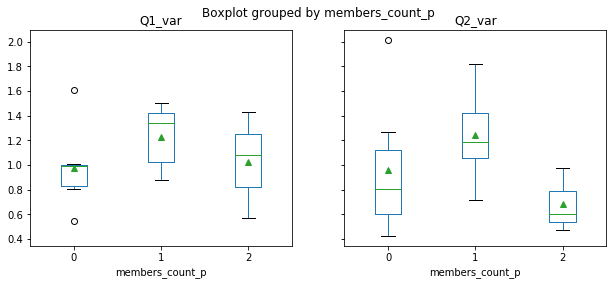

In [56]:
compare_groups(company_dyads_annual_full_clean,'_var','members_count_p',[1],[0,2])

1    7
0    7
2    3
Name: members_count_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 7 , 3
Q1, p: 0.32, Means: 0.97 (0.12),1.03(0.25)
KS test - Q1: group a: 0.00   group b: 0.05
Q2, p: 0.32, Means: 0.96 (0.21),0.68(0.15)
KS test - Q2: group a: 0.00   group b: 0.07


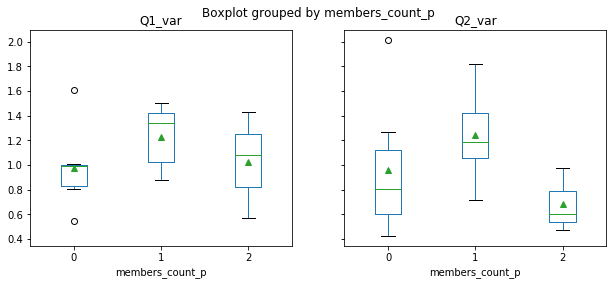

In [57]:
compare_groups(company_dyads_annual_full_clean,'_var','members_count_p',[0],[2])

### regression

In [58]:
import statsmodels.api as sm


In [59]:
company_dyads_annual_full_clean["members_countXminutes_62"] = company_dyads_annual_full_clean["members_count"] * company_dyads_annual_full_clean["minutes_62"]
company_dyads_annual_full_clean["members_countXminutes_62_p"] = company_dyads_annual_full_clean["members_count"] * company_dyads_annual_full_clean["minutes_62_p"]
company_dyads_annual_full_clean["members_countXminutes_62_p4"] = company_dyads_annual_full_clean["members_count"] * company_dyads_annual_full_clean["minutes_62_p4"]
company_dyads_annual_full_clean["members_countXminutes_62_p8"] = company_dyads_annual_full_clean["members_count"] * company_dyads_annual_full_clean["minutes_62_p8"]

company_dyads_annual_full_clean["members_count_pXminutes_62_p"] = company_dyads_annual_full_clean["members_count_p"] * company_dyads_annual_full_clean["minutes_62_p"]

#X = company_dyads_annual_full_clean[["members_count","minutes_62","members_countXminutes_62"]]
#X = company_dyads_annual_full_clean[["members_count","minutes_62_norm_members_p","minutes_out_62_norm_members_p"]]
#X = company_dyads_annual_full_clean[["members_count","minutes_62","members_countXminutes_62"]]
#X = company_dyads_annual_full_clean[["minutes_62_p"]]
#X = company_dyads_annual_full_clean[["members_count","minutes_62_p","members_countXminutes_62_p"]]

#X = company_dyads_annual_full_clean[["members_count","minutes_62","members_countXminutes_62"]]

# try log
#company_dyads_annual_full_clean["log_minutes_62"] = np.log(company_dyads_annual_full_clean[["minutes_62"]])
#company_dyads_annual_full_clean["members_countXlog_minutes_62"] = company_dyads_annual_full_clean["members_count"] * company_dyads_annual_full_clean["log_minutes_62"]
#X = company_dyads_annual_full_clean[["members_count","log_minutes_62","members_countXlog_minutes_62"]]

# try center the number of members
#company_dyads_annual_full_clean["members_count_centered"] = abs(company_dyads_annual_full_clean["members_count"]-6)
#company_dyads_annual_full_clean["members_count_centeredXminutes_62_p"] = company_dyads_annual_full_clean["members_count_centered"] * company_dyads_annual_full_clean["minutes_62_p"]
#X = company_dyads_annual_full_clean[["members_count_centered","minutes_62_p","members_count_centeredXminutes_62_p"]]

# Best so far -  try normalizing
ndf=(company_dyads_annual_full_clean-company_dyads_annual_full_clean.mean())/company_dyads_annual_full_clean.std()
#X = ndf[["members_count","minutes_62_p","members_countXminutes_62_p"]]
X = ndf[["members_count_p","minutes_62_p","members_count_pXminutes_62_p"]]




X = sm.add_constant(X)
y = company_dyads_annual_full_clean["Q1_mean"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

/home/orenled/Envs/rhythm-private-analysis-deltav18-anon/lib/python2.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Q1_mean   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     2.694
Date:                Wed, 13 Feb 2019   Prob (F-statistic):             0.0893
Time:                        19:20:20   Log-Likelihood:                -2.2731
No. Observations:                  17   AIC:                             12.55
Df Residuals:                      13   BIC:                             15.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            5.7165      0.077     74.520      0.000       5.551       5.882
members_count_p                  0.3818      0.183      2.087      0.057      -0.013       0.777
minutes_62_p                     0.2237      0.126      1.773      0.100      -0.049       0.496
members_count_pXminutes_62_p    -0.3872      0.227     -1.707      0.112      -0.877       0.103
==============================================================================
Omnibus:                        1.821   Durbin-Watson:                   2.984
Prob(Omnibus):                  0.402   Jarque-Bera (JB):                1.062
Skew:                          -0.260   Prob(JB):                        0.588
Kurtosis:                       1.891   Cond. No.                         5.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
X = ndf[["members_count_p"]]




X = sm.add_constant(X)
y = company_dyads_annual_full_clean["Q1_mean"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

/home/orenled/Envs/rhythm-private-analysis-deltav18-anon/lib/python2.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Q1_mean   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     3.944
Date:                Wed, 13 Feb 2019   Prob (F-statistic):             0.0656
Time:                        19:20:20   Log-Likelihood:                -4.3979
No. Observations:                  17   AIC:                             12.80
Df Residuals:                      15   BIC:                             14.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.7165      0.081     70.642      0.000       5.544       5.889
members_count_p     0.1657      0.083      1.986      0.066      -0.012       0.343
==============================================================================
Omnibus:                        0.522   Durbin-Watson:                   2.726
Prob(Omnibus):                  0.770   Jarque-Bera (JB):                0.573
Skew:                          -0.118   Prob(JB):                        0.751
Kurtosis:                       2.132   Cond. No.                         1.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
X = ndf[["minutes_62_p"]]




X = sm.add_constant(X)
y = company_dyads_annual_full_clean["Q1_mean"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

/home/orenled/Envs/rhythm-private-analysis-deltav18-anon/lib/python2.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Q1_mean   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     3.206
Date:                Wed, 13 Feb 2019   Prob (F-statistic):             0.0936
Time:                        19:20:20   Log-Likelihood:                -4.7357
No. Observations:                  17   AIC:                             13.47
Df Residuals:                      15   BIC:                             15.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.7165      0.083     69.252      0.000       5.541       5.892
minutes_62_p     0.1524      0.085      1.791      0.094      -0.029       0.334
==============================================================================
Omnibus:                        0.480   Durbin-Watson:                   3.022
Prob(Omnibus):                  0.787   Jarque-Bera (JB):                0.577
Skew:                          -0.267   Prob(JB):                        0.749
Kurtosis:                       2.273   Cond. No.                         1.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Explore - daily survey data - inter team

### Correlation matrices

In [62]:
pairplot_columns = ['minutes_out_62','minutes_out_62_p','minutes_out_62_norm_members','minutes_out_62_norm_members_p','minutes_out_62_c2c_mean','minutes_out_62_c2c_var','minutes_out_62_c2c_std','minutes_out_62_c2c_entropy','members_count','dyads_count']
q1_columns = ['Q1_mean','Q1_min','Q1_var','Q1_std','Q1_mean_daily_mean','Q1_mean_daily_var','Q1_mean_daily_std','Q1_mean_member_mean','Q1_mean_member_var','Q1_mean_member_std']+pairplot_columns
q2_columns = ['Q2_mean','Q2_min','Q2_var','Q2_std','Q2_mean_daily_mean','Q2_mean_daily_var','Q2_mean_daily_std','Q2_mean_member_mean','Q2_mean_member_var','Q2_mean_member_std']+pairplot_columns

In [63]:
s = create_style_corr_table(company_dyads_annual_full_clean[q1_columns])
imgkit.from_string(s.render(), '/home/orenled/temp/q1_out_corr.png')
s

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,Q1 mean,Q1 min,Q1 var,Q1 std,Q1 mean da ily mean,Q1 mean da ily var,Q1 mean da ily std,Q1 mean me mber mean,Q1 mean me mber var,Q1 mean me mber std,minutes ou t 62,minutes ou t 62 p,minutes ou t 62 norm members,minutes ou t 62 norm members p,minutes ou t 62 c2c m ean,minutes ou t 62 c2c v ar,minutes ou t 62 c2c s td,minutes ou t 62 c2c e ntropy,members co unt,dyads coun t
Q1 mean,1,0.24,-0.2,-0.19,0.99,-0.4,-0.36,0.88,0.14,0.28,0.56,0.57,0.28,0.18,0.56,0.49,0.56,0.1,0.39,0.29
Q1 min,0.24,1,-0.73,-0.72,0.33,-0.48,-0.44,0.12,0.044,0.055,0.15,0.085,0.32,0.26,0.15,0.14,0.064,0.29,-0.14,-0.054
Q1 var,-0.2,-0.73,1,1,-0.27,0.58,0.6,-0.086,0.035,0.018,-0.3,-0.25,-0.42,-0.43,-0.3,-0.23,-0.18,-0.48,0.014,-0.12
Q1 std,-0.19,-0.72,1,1,-0.26,0.59,0.61,-0.086,0.058,0.042,-0.27,-0.22,-0.39,-0.4,-0.27,-0.2,-0.16,-0.46,-0.00095,-0.14
Q1 mean da ily mean,0.99,0.33,-0.27,-0.26,1,-0.46,-0.42,0.82,0.18,0.3,0.57,0.56,0.32,0.19,0.57,0.48,0.54,0.15,0.36,0.28
Q1 mean da ily var,-0.4,-0.48,0.58,0.59,-0.46,1,0.99,-0.25,-0.21,-0.28,-0.27,-0.038,-0.046,0.031,-0.27,-0.039,-0.046,-0.58,-0.53,-0.59
Q1 mean da ily std,-0.36,-0.44,0.6,0.61,-0.42,0.99,1,-0.24,-0.15,-0.21,-0.23,-0.0043,0.014,0.083,-0.23,-0.0073,-0.023,-0.54,-0.6,-0.67
Q1 mean me mber mean,0.88,0.12,-0.086,-0.086,0.82,-0.25,-0.24,1,-0.26,-0.084,0.58,0.57,0.29,0.23,0.58,0.47,0.6,0.037,0.47,0.36
Q1 mean me mber var,0.14,0.044,0.035,0.058,0.18,-0.21,-0.15,-0.26,1,0.97,-0.23,-0.19,-0.21,-0.29,-0.23,-0.19,-0.29,0.17,-0.16,-0.13
Q1 mean me mber std,0.28,0.055,0.018,0.042,0.3,-0.28,-0.21,-0.084,0.97,1,-0.12,-0.11,-0.15,-0.23,-0.12,-0.11,-0.2,0.19,-0.074,-0.077


In [64]:
s = create_style_corr_table(company_dyads_annual_full_clean[q2_columns])
imgkit.from_string(s.render(), '/home/orenled/temp/q2_out_corr.png')
s

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,Q2 mean,Q2 min,Q2 var,Q2 std,Q2 mean da ily mean,Q2 mean da ily var,Q2 mean da ily std,Q2 mean me mber mean,Q2 mean me mber var,Q2 mean me mber std,minutes ou t 62,minutes ou t 62 p,minutes ou t 62 norm members,minutes ou t 62 norm members p,minutes ou t 62 c2c m ean,minutes ou t 62 c2c v ar,minutes ou t 62 c2c s td,minutes ou t 62 c2c e ntropy,members co unt,dyads coun t
Q2 mean,1,0.48,-0.4,-0.39,0.99,-0.4,-0.4,0.93,0.23,0.31,0.62,0.61,0.42,0.33,0.62,0.57,0.61,0.2,0.3,0.22
Q2 min,0.48,1,-0.74,-0.77,0.46,-0.71,-0.69,0.47,-0.088,-0.13,0.35,0.21,0.36,0.34,0.35,0.036,0.11,0.58,0.2,0.26
Q2 var,-0.4,-0.74,1,0.99,-0.39,0.8,0.8,-0.38,0.45,0.42,-0.38,-0.24,-0.38,-0.43,-0.38,-0.12,-0.14,-0.74,-0.22,-0.3
Q2 std,-0.39,-0.77,0.99,1,-0.37,0.8,0.81,-0.37,0.45,0.42,-0.35,-0.2,-0.37,-0.41,-0.35,-0.098,-0.13,-0.7,-0.22,-0.32
Q2 mean da ily mean,0.99,0.46,-0.39,-0.37,1,-0.42,-0.43,0.91,0.28,0.37,0.61,0.59,0.4,0.3,0.61,0.56,0.6,0.22,0.31,0.24
Q2 mean da ily var,-0.4,-0.71,0.8,0.8,-0.42,1,0.98,-0.35,0.00046,-0.012,-0.28,-0.045,-0.17,-0.18,-0.28,0.023,-0.035,-0.66,-0.4,-0.45
Q2 mean da ily std,-0.4,-0.69,0.8,0.81,-0.43,0.98,1,-0.36,0.037,-0.0051,-0.26,-0.015,-0.1,-0.1,-0.26,0.014,-0.043,-0.6,-0.51,-0.57
Q2 mean me mber mean,0.93,0.47,-0.38,-0.37,0.91,-0.35,-0.36,1,0.029,0.13,0.62,0.63,0.39,0.31,0.62,0.57,0.66,0.1,0.39,0.3
Q2 mean me mber var,0.23,-0.088,0.45,0.45,0.28,0.00046,0.037,0.029,1,0.95,-0.15,-0.21,-0.3,-0.39,-0.15,-0.068,-0.11,-0.19,0.093,0.04
Q2 mean me mber std,0.31,-0.13,0.42,0.42,0.37,-0.012,-0.0051,0.13,0.95,1,-0.05,-0.12,-0.28,-0.39,-0.05,0.037,0.022,-0.23,0.24,0.16


### Compare populations - high interaction vs low

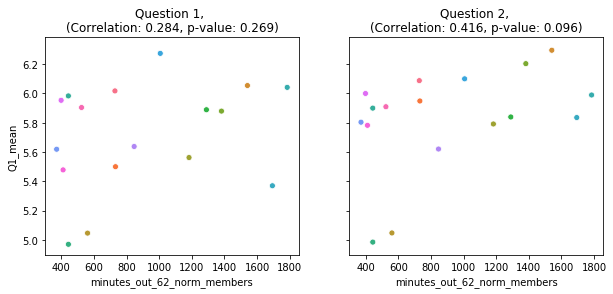

In [65]:
plot_corr(company_dyads_annual_full_clean.reset_index(), "_mean","minutes_out_62_norm_members","")

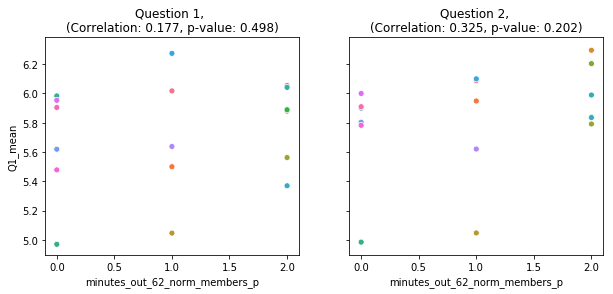

In [66]:
plot_corr(company_dyads_annual_full_clean.reset_index(), "_mean","minutes_out_62_norm_members_p","")

2    6
0    6
1    5
Name: minutes_out_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 6 , 6
Q1, p: 0.34, Means: 5.65 (0.16),5.80(0.11)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.15, Means: 5.73 (0.15),5.99(0.09)
KS test - Q2: group a: 0.00   group b: 0.00


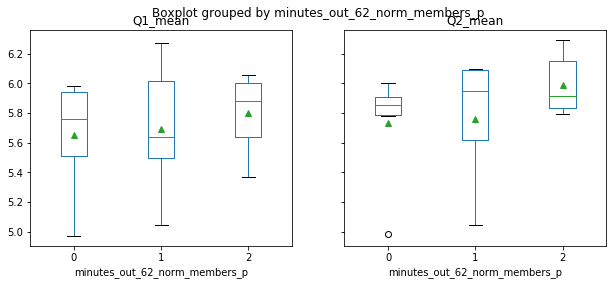

In [67]:
compare_groups(company_dyads_annual_full_clean,"_mean", 'minutes_out_62_norm_members_p', [0],[2])

2    6
0    6
1    5
Name: minutes_out_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 11 , 6
Q1, p: 0.02, Means: 1.20 (0.10),0.88(0.08)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.03, Means: 1.18 (0.14),0.74(0.12)
KS test - Q2: group a: 0.00   group b: 0.00


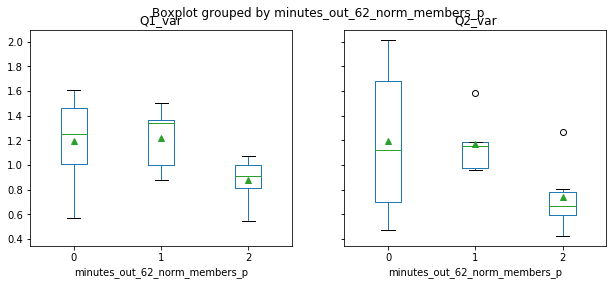

In [68]:
compare_groups(company_dyads_annual_full_clean,"_var", 'minutes_out_62_norm_members_p', [0,1],[2])

0    5
3    4
2    4
1    4
Name: minutes_out_62_norm_members_p4, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 13 , 4
Q1, p: 0.23, Means: 5.68 (0.11),5.84(0.16)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.04, Means: 5.76 (0.10),6.08(0.10)
KS test - Q2: group a: 0.00   group b: 0.00


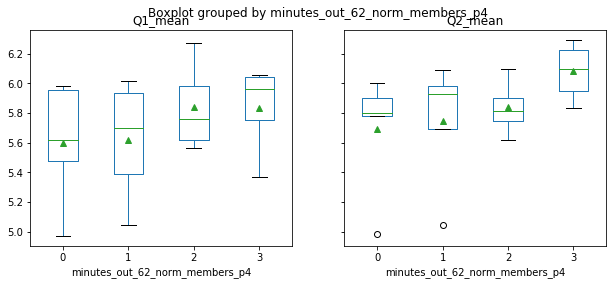

In [69]:
compare_groups(company_dyads_annual_full_clean,"_mean", 'minutes_out_62_norm_members_p4', [0,1,2],[3])

### Compare populations - high entroy vs low

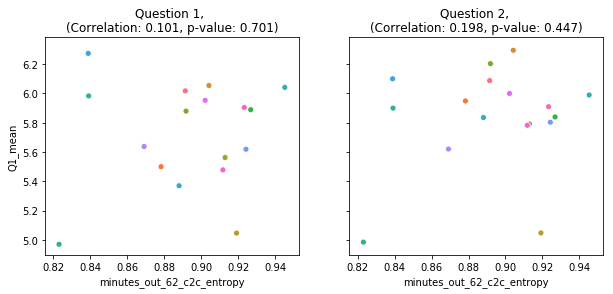

In [70]:
plot_corr(company_dyads_annual_full_clean.reset_index(), "_mean","minutes_out_62_c2c_entropy","")

2    6
0    6
1    5
Name: minutes_out_62_c2c_entropy_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 12 , 5
Q1, p: 0.16, Means: 5.65 (0.11),5.88(0.10)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.03, Means: 5.73 (0.10),6.07(0.09)
KS test - Q2: group a: 0.00   group b: 0.00


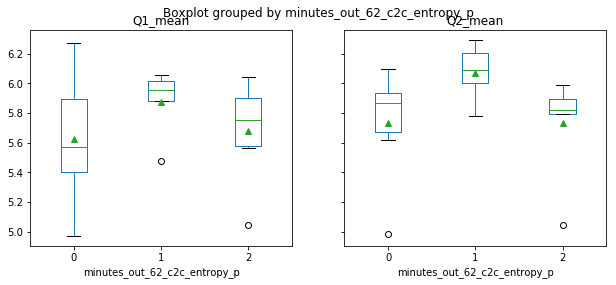

In [71]:
compare_groups(company_dyads_annual_full_clean,"_mean", 'minutes_out_62_c2c_entropy_p', [0,2],[1])

2    6
0    6
1    5
Name: minutes_out_62_c2c_entropy_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 12 , 5
Q1, p: 0.16, Means: 5.65 (0.11),5.88(0.10)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.03, Means: 5.73 (0.10),6.07(0.09)
KS test - Q2: group a: 0.00   group b: 0.00


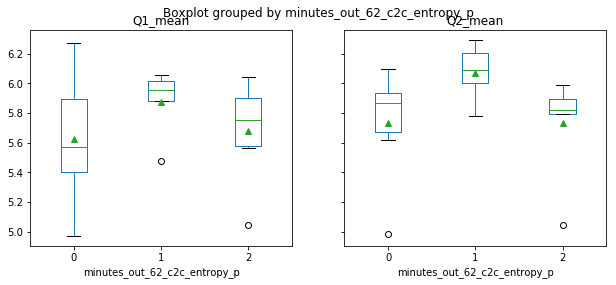

In [72]:
compare_groups(company_dyads_annual_full_clean,"_mean", 'minutes_out_62_c2c_entropy_p', [0,2],[1])

### regressions

## Explore - daily survey data, EIR/staff

In [73]:
pairplot_columns = ['','',]
pairplot_columns = ['minutes_eir_62','minutes_eir_62_p','minutes_eir_62_norm_members','minutes_eir_62_norm_members_p']
q1_columns = ['Q1_mean','Q1_min','Q1_var','Q1_std','Q1_mean_daily_mean','Q1_mean_daily_var','Q1_mean_daily_std','Q1_mean_member_mean','Q1_mean_member_var','Q1_mean_member_std']+pairplot_columns
q2_columns = ['Q2_mean','Q2_min','Q2_var','Q2_std','Q2_mean_daily_mean','Q2_mean_daily_var','Q2_mean_daily_std','Q2_mean_member_mean','Q2_mean_member_var','Q2_mean_member_std']+pairplot_columns

In [74]:
s = create_style_corr_table(company_dyads_annual_full_clean[q1_columns])
#imgkit.from_string(s.render(), '/home/orenled/temp/q1_out_corr.png')
s

,Q1 mean,Q1 min,Q1 var,Q1 std,Q1 mean da ily mean,Q1 mean da ily var,Q1 mean da ily std,Q1 mean me mber mean,Q1 mean me mber var,Q1 mean me mber std,minutes ei r 62,minutes ei r 62 p,minutes ei r 62 norm members,minutes ei r 62 norm members p
Q1 mean,1,0.24,-0.2,-0.19,0.99,-0.4,-0.36,0.88,0.14,0.28,0.44,0.39,0.18,0.2
Q1 min,0.24,1,-0.73,-0.72,0.33,-0.48,-0.44,0.12,0.044,0.055,0.21,0.085,0.35,0.34
Q1 var,-0.2,-0.73,1,1,-0.27,0.58,0.6,-0.086,0.035,0.018,-0.19,-0.073,-0.35,-0.39
Q1 std,-0.19,-0.72,1,1,-0.26,0.59,0.61,-0.086,0.058,0.042,-0.15,-0.03,-0.31,-0.34
Q1 mean da ily mean,0.99,0.33,-0.27,-0.26,1,-0.46,-0.42,0.82,0.18,0.3,0.46,0.37,0.21,0.19
Q1 mean da ily var,-0.4,-0.48,0.58,0.59,-0.46,1,0.99,-0.25,-0.21,-0.28,-0.086,0.13,0.089,0.13
Q1 mean da ily std,-0.36,-0.44,0.6,0.61,-0.42,0.99,1,-0.24,-0.15,-0.21,-0.023,0.19,0.15,0.18
Q1 mean me mber mean,0.88,0.12,-0.086,-0.086,0.82,-0.25,-0.24,1,-0.26,-0.084,0.46,0.45,0.17,0.27
Q1 mean me mber var,0.14,0.044,0.035,0.058,0.18,-0.21,-0.15,-0.26,1,0.97,-0.078,-0.14,-0.1,-0.2
Q1 mean me mber std,0.28,0.055,0.018,0.042,0.3,-0.28,-0.21,-0.084,0.97,1,0.03,-0.066,-0.058,-0.12


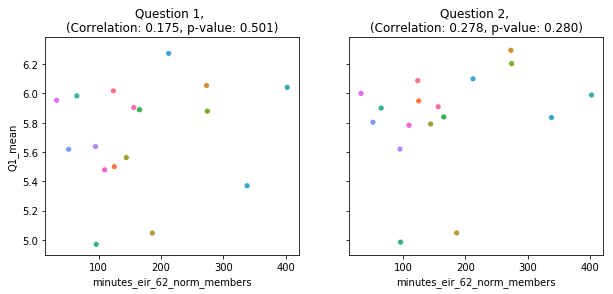

In [75]:
plot_corr(company_dyads_annual_full_clean.reset_index(), "_mean","minutes_eir_62_norm_members","")

2    6
0    6
1    5
Name: minutes_eir_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 6 , 6
Q1, p: 0.19, Means: 5.61 (0.15),5.78(0.19)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.06, Means: 5.68 (0.15),5.91(0.18)
KS test - Q2: group a: 0.00   group b: 0.00


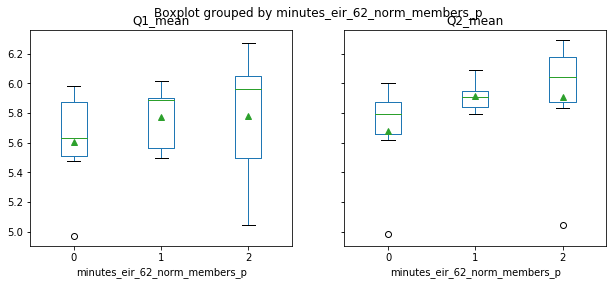

In [112]:
compare_groups(company_dyads_annual_full_clean,"_mean", 'minutes_eir_62_norm_members_p', [0],[2])

2    6
0    6
1    5
Name: minutes_eir_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 6 , 5
Q1, p: 0.26, Means: 1.20 (0.16),1.15(0.16)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.16, Means: 1.23 (0.25),0.96(0.14)
KS test - Q2: group a: 0.00   group b: 0.01


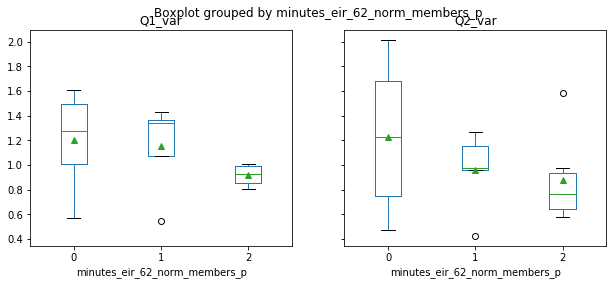

In [77]:
compare_groups(company_dyads_annual_full_clean,"_var", 'minutes_eir_62_norm_members_p', [0],[1])

0    5
3    4
2    4
1    4
Name: minutes_eir_62_norm_members_p4, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 5 , 4
Q1, p: 0.20, Means: 5.63 (0.18),5.84(0.16)
KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.06, Means: 5.66 (0.18),6.08(0.10)
KS test - Q2: group a: 0.00   group b: 0.00


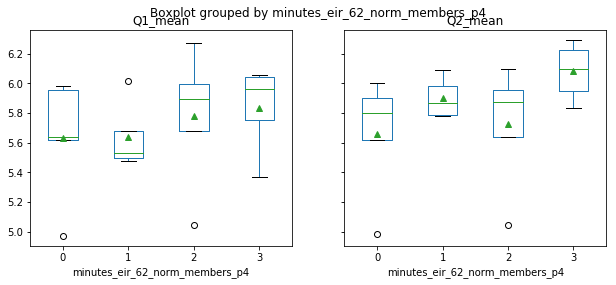

In [78]:
compare_groups(company_dyads_annual_full_clean,"_mean", 'minutes_eir_62_norm_members_p4', [0],[3])

# Objective performance / Milestone data

## Explore - milestone data - intra team

### Correlation between subjective (agg daily) and performance

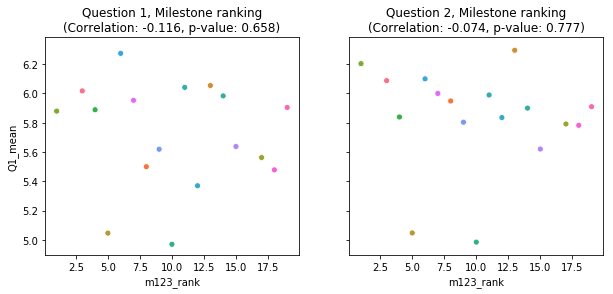

In [79]:
#c = company_dyads_annual_full_clean[['Q1_mean']].join(company_panel['m123_rank']).reset_index().drop('company',axis=1)
#c.plot.scatter(x='Q1_mean',y='m123_rank')
#c.corr()
plot_corr(company_dyads_annual_full_clean.reset_index(),'_mean','m123_rank','Milestone ranking')

### Correlation matrices

In [80]:
pairplot_columns = ['minutes_62','minutes_62_p','minutes_62_norm_members','minutes_62_norm_members_p','minutes_62_norm_dyads','minutes_62_norm_dyads_p','minutes_62_m2m_mean','minutes_62_m2m_var','minutes_62_m2m_std','minutes_62_m2m_entropy','minutes_62_m2c_entropy','members_count','dyads_count']
milestone_columns = ['m123_rank']+pairplot_columns

In [81]:
s = create_style_corr_table(company_dyads_annual_full_clean[milestone_columns])
imgkit.from_string(s.render(), '/home/orenled/temp/m_corr.png')
s

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,m123 rank,minutes 62,minutes 62 p,minutes 62 norm memb ers,minutes 62 norm memb ers p,minutes 62 norm dyad s,minutes 62 norm dyad s p,minutes 62 m2m mean,minutes 62 m2m var,minutes 62 m2m std,minutes 62 m2m entro py,minutes 62 m2c entro py,members co unt,dyads coun t
m123 rank,1,-0.3,-0.2,-0.34,-0.31,-0.21,-0.28,-0.21,-0.43,-0.45,0.2,0.42,-0.075,-0.053
minutes 62,-0.3,1,0.88,0.81,0.88,0.29,0.0021,0.29,0.095,0.17,0.29,-0.7,0.74,0.72
minutes 62 p,-0.2,0.88,1,0.8,0.92,0.36,0.083,0.36,0.25,0.33,0.16,-0.59,0.65,0.59
minutes 62 norm memb ers,-0.34,0.81,0.8,1,0.88,0.77,0.47,0.77,0.4,0.5,0.38,-0.55,0.26,0.2
minutes 62 norm memb ers p,-0.31,0.88,0.92,0.88,1,0.52,0.25,0.52,0.26,0.35,0.29,-0.53,0.52,0.48
minutes 62 norm dyad s,-0.21,0.29,0.36,0.77,0.52,1,0.81,1,0.45,0.54,0.35,-0.11,-0.38,-0.39
minutes 62 norm dyad s p,-0.28,0.0021,0.083,0.47,0.25,0.81,1,0.81,0.64,0.7,0.13,0.031,-0.6,-0.58
minutes 62 m2m mean,-0.21,0.29,0.36,0.77,0.52,1,0.81,1,0.45,0.54,0.35,-0.11,-0.38,-0.39
minutes 62 m2m var,-0.43,0.095,0.25,0.4,0.26,0.45,0.64,0.45,1,0.98,-0.59,-0.17,-0.36,-0.35
minutes 62 m2m std,-0.45,0.17,0.33,0.5,0.35,0.54,0.7,0.54,0.98,1,-0.51,-0.26,-0.36,-0.34


### Compare populations - high interaction vs low

2    6
0    6
1    5
Name: minutes_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 6 , 11
------------------------
m123_rank
p: 0.05, Means: 13.17 (1.99),8.45(1.55)
KS test - group a: 0.00   group b: 0.00


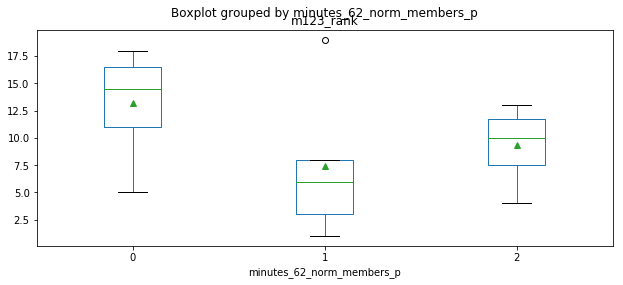

In [82]:
compare_groups_milestons(company_dyads_annual_full_clean,"m123_rank", 'minutes_62_norm_members_p', [0],[1,2])


In [83]:
13.17 - 8.45

4.720000000000001

2    6
0    6
1    5
Name: minutes_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 5 , 6
------------------------
m123_rank
p: 0.16, Means: 7.40 (3.14),9.33(1.38)
KS test - group a: 0.00   group b: 0.00


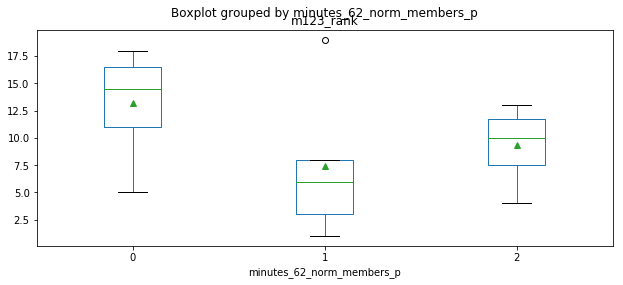

In [84]:
compare_groups_milestons(company_dyads_annual_full_clean,"m123_rank", 'minutes_62_norm_members_p', [1],[2])


/home/orenled/Envs/rhythm-private-analysis-deltav18-anon/lib/python2.7/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
2019-04-07 17:01:17,062 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/orenled/Envs/rhythm-private-analysis-deltav17/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


2    6
0    6
1    5
Name: minutes_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7fe254516aa0>
Group sizes:  , 6 , 11
------------------------
m123_total
p: 0.05, Means: 15250.00 (497.83),16371.36(486.90), medians: 14925.00 16700.00
KS test - group a: 0.00   group b: 0.00


2019-04-07 17:01:17,234 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans (u'/home/orenled/Envs/rhythm-private-analysis-deltav17/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


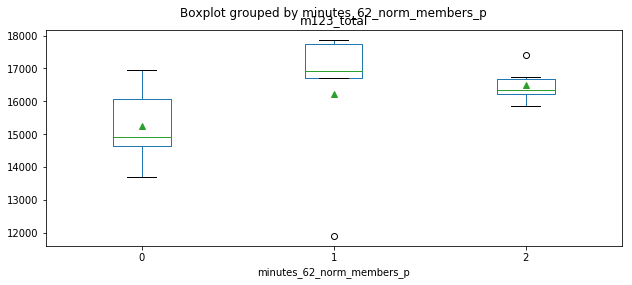

In [65]:
compare_groups_milestons(company_dyads_annual_full_clean,"m123_total", 'minutes_62_norm_members_p', [0],[1,2])


### Compare populations - high entropy vs low

2    6
0    6
1    5
Name: minutes_62_m2c_entropy_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 6 , 11
------------------------
m123_rank
p: 0.06, Means: 7.33 (0.88),11.64(1.85), medians: 7.50 13.00
KS test - group a: 0.00   group b: 0.00


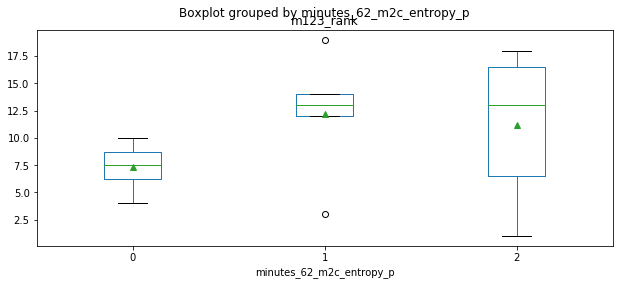

In [115]:
compare_groups_milestons(company_dyads_annual_full_clean,"m123_rank", 'minutes_62_m2c_entropy_p', [0],[1,2])

2    6
0    6
1    5
Name: minutes_62_m2c_entropy_p, dtype: int64
Test: <function mannwhitneyu at 0x7fe254516aa0>
Group sizes:  , 6 , 11
------------------------
m123_total
p: 0.06, Means: 16780.00 (143.85),15536.82(537.45), medians: 16715.00 15850.00
KS test - group a: 0.00   group b: 0.00


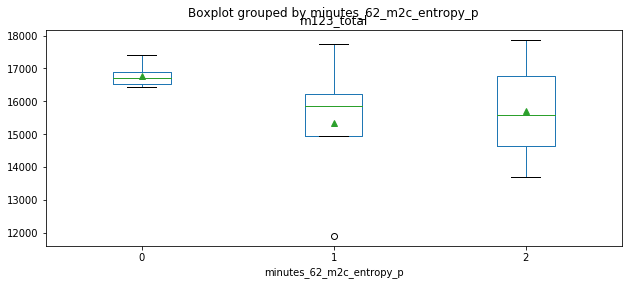

In [67]:
compare_groups_milestons(company_dyads_annual_full_clean,"m123_total", 'minutes_62_m2c_entropy_p', [0],[1,2])

In [86]:
11.64 - 7.33

4.3100000000000005

0    5
3    4
2    4
1    4
Name: minutes_62_m2c_entropy_p4, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 5 , 4
------------------------
m123_rank
p: 0.01, Means: 7.20 (1.07),15.25(1.55)
KS test - group a: 0.00   group b: 0.00


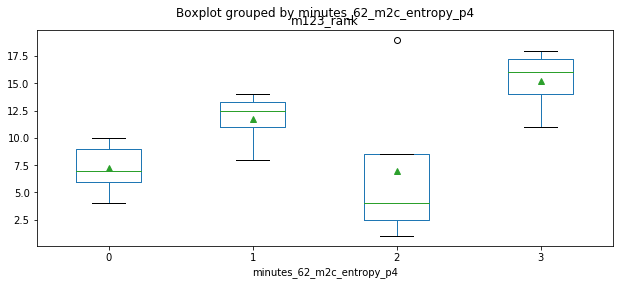

In [87]:
compare_groups_milestons(company_dyads_annual_full_clean,"m123_rank", 'minutes_62_m2c_entropy_p4', [0],[3])

In [88]:
company_dyads_annual_full_clean[['m123_rank','m123_rank_p']].sort_values(by='m123_rank')

,m123_rank,m123_rank_p
company,,
Company F,1,0
Company A,3,0
Company G,4,0
Company D,5,0
Company M,6,0
Company P,7,0
Company B,8,1
Company N,9,1
Company H,10,1


In [89]:
len(company_dyads_annual_full_clean)

17

In [90]:
#compare_groups_milestons(company_dyads_annual_full_clean,"m123_rank", 'minutes_62_m2m_entropy_p', [0],[1,2])

### Team size vs milestones

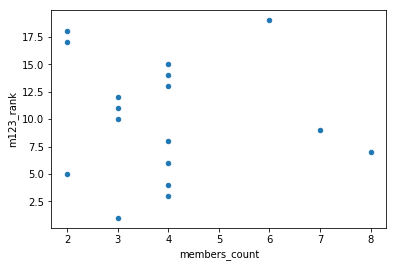

In [91]:
company_dyads_annual_full_clean.plot.scatter('members_count','m123_rank')

1    7
0    7
2    3
Name: members_count_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 7 , 3
------------------------
m123_rank
p: 0.50, Means: 10.57 (2.30),11.67(3.71)
KS test - group a: 0.00   group b: 0.00


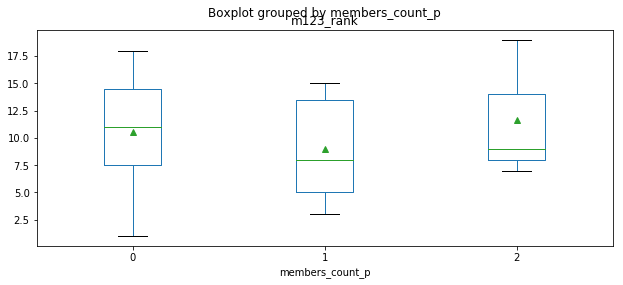

In [92]:
compare_groups_milestons(company_dyads_annual_full_clean,'m123_rank','members_count_p',[0],[2])

1    7
0    7
2    3
Name: members_count_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 7 , 3
------------------------
m123_rank
p: 0.25, Means: 9.00 (1.88),11.67(3.71)
KS test - group a: 0.00   group b: 0.00


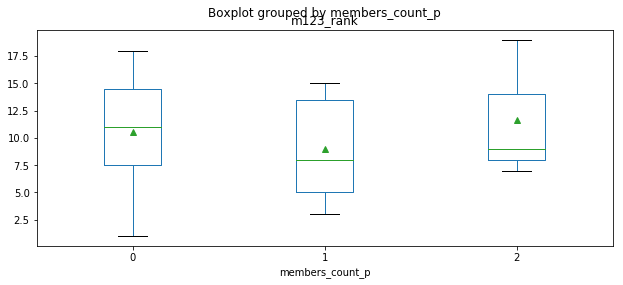

In [93]:
compare_groups_milestons(company_dyads_annual_full_clean,'m123_rank','members_count_p',[1],[2])

1    7
0    7
2    3
Name: members_count_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 10 , 7
------------------------
m123_rank
p: 0.26, Means: 10.90 (1.85),9.00(1.88)
KS test - group a: 0.00   group b: 0.00


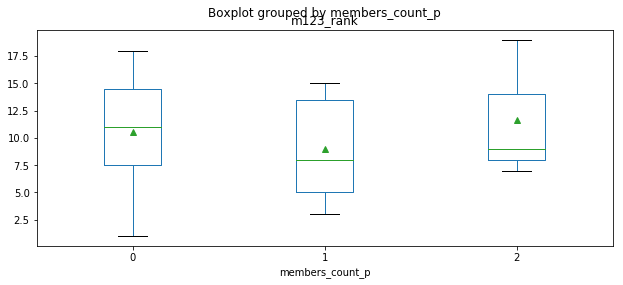

In [94]:
compare_groups_milestons(company_dyads_annual_full_clean,'m123_rank','members_count_p',[0,2],[1])

0    9
1    8
Name: is_46, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 9 , 8
------------------------
m123_rank
p: 0.48, Means: 10.00 (1.80),10.25(2.05)
KS test - group a: 0.00   group b: 0.00


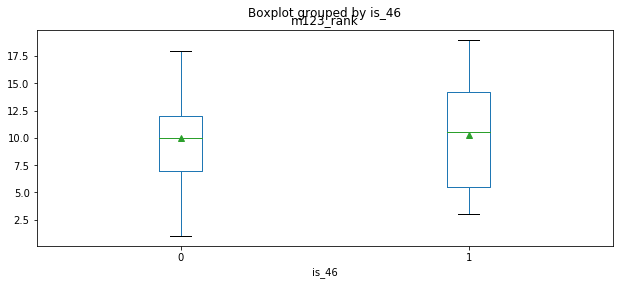

In [95]:
compare_groups_milestons(company_dyads_annual_full_clean,'m123_rank','is_46',[0],[1])

### Regressions

In [96]:
X = company_dyads_annual_full_clean[["members_count","minutes_62_p","members_countXminutes_62_p"]]
#X = ndf[["members_count_p","minutes_62_p","members_count_pXminutes_62_p"]]


X = sm.add_constant(X)
y = company_dyads_annual_full_clean["m123_rank"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

/home/orenled/Envs/rhythm-private-analysis-deltav18-anon/lib/python2.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              m123_rank   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                 -0.143
Method:                 Least Squares   F-statistic:                    0.3345
Date:                Wed, 13 Feb 2019   Prob (F-statistic):              0.801
Time:                        19:20:31   Log-Likelihood:                -51.702
No. Observations:                  17   AIC:                             111.4
Df Residuals:                      13   BIC:                             114.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         14.5370      7.506      1.937      0.075      -1.679      30.753
members_count                 -1.0242      2.444     -0.419      0.682      -6.303       4.255
minutes_62_p                  -4.2904      4.877     -0.880      0.395     -14.826       6.245
members_countXminutes_62_p     0.8101      1.325      0.612      0.551      -2.052       3.672
==============================================================================
Omnibus:                        1.215   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.545   Jarque-Bera (JB):                0.792
Skew:                          -0.031   Prob(JB):                        0.673
Kurtosis:                       1.944   Cond. No.                         51.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Explore - milestone data - inter team

### Corelation matrices

In [97]:
pairplot_columns = ['minutes_out_62','minutes_out_62_p','minutes_out_62_norm_members','minutes_out_62_norm_members_p','minutes_out_62_c2c_mean','minutes_out_62_c2c_var','minutes_out_62_c2c_std','minutes_out_62_c2c_entropy','members_count','dyads_count']
milestone_columns = ['m123_rank']+pairplot_columns

In [98]:
s = create_style_corr_table(company_dyads_annual_full_clean[milestone_columns])
imgkit.from_string(s.render(), '/home/orenled/temp/m_out_corr.png')
s

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,m123 rank,minutes ou t 62,minutes ou t 62 p,minutes ou t 62 norm members,minutes ou t 62 norm members p,minutes ou t 62 c2c m ean,minutes ou t 62 c2c v ar,minutes ou t 62 c2c s td,minutes ou t 62 c2c e ntropy,members co unt,dyads coun t
m123 rank,1,-0.19,-0.35,-0.11,-0.25,-0.19,-0.24,-0.27,0.06,-0.075,-0.053
minutes ou t 62,-0.19,1,0.92,0.83,0.71,1,0.86,0.89,0.26,0.13,0.033
minutes ou t 62 p,-0.35,0.92,1,0.78,0.67,0.92,0.88,0.9,0.14,0.043,-0.058
minutes ou t 62 norm members,-0.11,0.83,0.78,1,0.93,0.83,0.73,0.72,0.27,-0.38,-0.43
minutes ou t 62 norm members p,-0.25,0.71,0.67,0.93,1,0.71,0.62,0.61,0.3,-0.47,-0.51
minutes ou t 62 c2c m ean,-0.19,1,0.92,0.83,0.71,1,0.86,0.89,0.26,0.13,0.033
minutes ou t 62 c2c v ar,-0.24,0.86,0.88,0.73,0.62,0.86,1,0.97,-0.13,0.0064,-0.099
minutes ou t 62 c2c s td,-0.27,0.89,0.9,0.72,0.61,0.89,0.97,1,-0.14,0.11,-0.012
minutes ou t 62 c2c e ntropy,0.06,0.26,0.14,0.27,0.3,0.26,-0.13,-0.14,1,0.093,0.17
members co unt,-0.075,0.13,0.043,-0.38,-0.47,0.13,0.0064,0.11,0.093,1,0.98


### Compare populations - high interaction vs low (vs medium?)

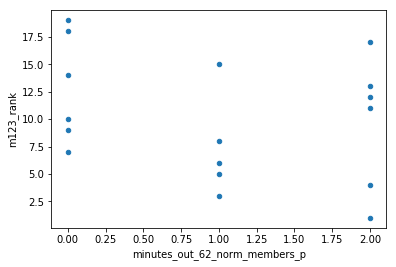

In [99]:
company_dyads_annual_full_clean.plot.scatter(x='minutes_out_62_norm_members_p',y='m123_rank')

2    6
0    6
1    5
Name: minutes_out_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7fe254516aa0>
Group sizes:  , 12 , 5
------------------------
m123_rank
p: 0.09, Means: 11.25 (1.59),7.40(2.06), medians: 11.50 6.00
KS test - group a: 0.00   group b: 0.00


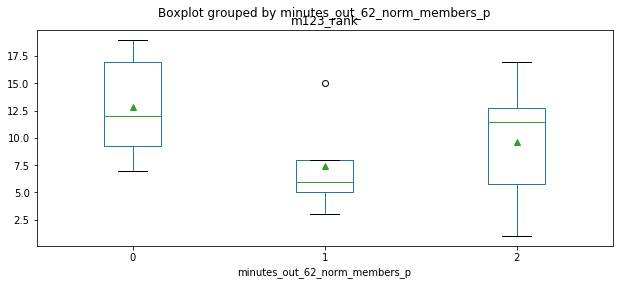

In [69]:
compare_groups_milestons(company_dyads_annual_full_clean,"m123_rank", 'minutes_out_62_norm_members_p', [0,2],[1])

In [101]:
11.25 -7.40

3.8499999999999996

2    6
0    6
1    5
Name: minutes_out_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 6 , 6
------------------------
m123_rank
p: 0.24, Means: 12.83 (2.02),9.67(2.44)
KS test - group a: 0.00   group b: 0.00


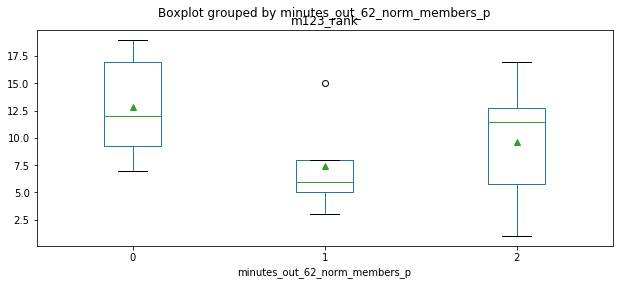

In [102]:
compare_groups_milestons(company_dyads_annual_full_clean,"m123_rank", 'minutes_out_62_norm_members_p', [0],[2])

0    5
3    4
2    4
1    4
Name: minutes_out_62_norm_members_p4, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 5 , 4
------------------------
m123_rank
p: 0.20, Means: 11.60 (1.96),8.75(3.57)
KS test - group a: 0.00   group b: 0.00


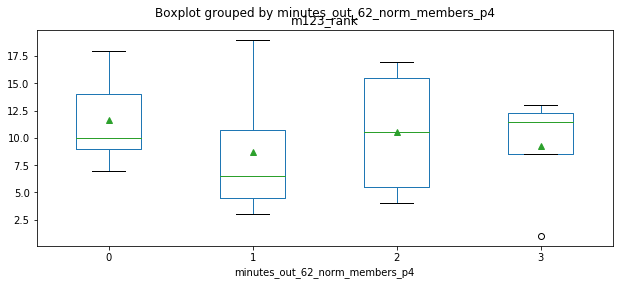

In [103]:
compare_groups_milestons(company_dyads_annual_full_clean,"m123_rank", 'minutes_out_62_norm_members_p4', [0],[1])

### Compare populations - high entropy vs low (vs medium?)

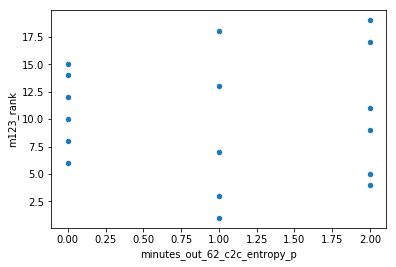

In [104]:
company_dyads_annual_full_clean.plot.scatter(x='minutes_out_62_c2c_entropy_p',y='m123_rank')

2    6
0    6
1    5
Name: minutes_out_62_c2c_entropy_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 11 , 6
------------------------
m123_rank
p: 0.40, Means: 9.73 (1.58),10.83(2.51)
KS test - group a: 0.00   group b: 0.00


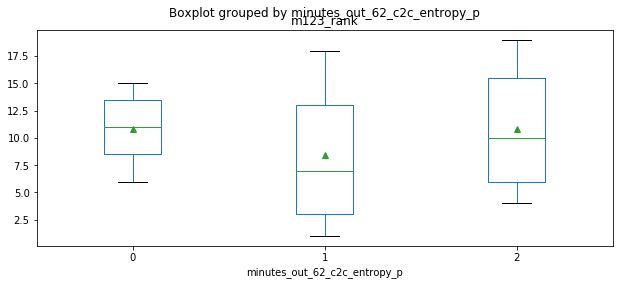

In [105]:
compare_groups_milestons(company_dyads_annual_full_clean,"m123_rank", 'minutes_out_62_c2c_entropy_p', [0,1],[2])

## Explore - daily survey data, EIR/staff

In [106]:
pairplot_columns = ['minutes_eir_62','minutes_eir_62_p','minutes_eir_62_norm_members','minutes_eir_62_norm_members_p']
milestone_columns = ['m123_rank']+pairplot_columns

In [107]:
s = create_style_corr_table(company_dyads_annual_full_clean[milestone_columns])
imgkit.from_string(s.render(), '/home/orenled/temp/m_eir_corr.png')
s

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,m123 rank,minutes ei r 62,minutes ei r 62 p,minutes ei r 62 norm members,minutes ei r 62 norm members p
m123 rank,1,-0.061,-0.17,-0.1,-0.33
minutes ei r 62,-0.061,1,0.92,0.87,0.78
minutes ei r 62 p,-0.17,0.92,1,0.81,0.83
minutes ei r 62 norm members,-0.1,0.87,0.81,1,0.87
minutes ei r 62 norm members p,-0.33,0.78,0.83,0.87,1


2    6
0    6
1    5
Name: minutes_eir_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f5cc0615aa0>
Group sizes:  , 6 , 6
------------------------
m123_rank
p: 0.09, Means: 12.17 (1.70),8.00(1.93), medians: 12.00 8.50
KS test - group a: 0.00   group b: 0.00


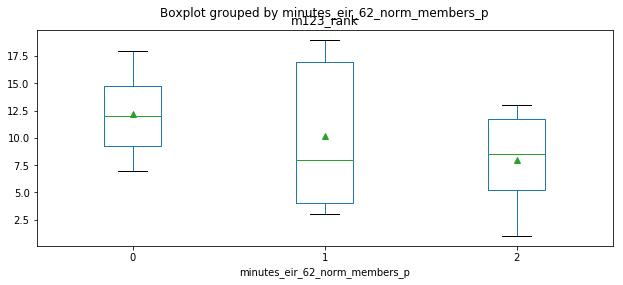

In [114]:
compare_groups_milestons(company_dyads_annual_full_clean,"m123_rank", 'minutes_eir_62_norm_members_p', [0],[2])

In [109]:
12.17 - 8

4.17